# Crash Course in Forecasting: Time Series Analysis for Personal Health Data

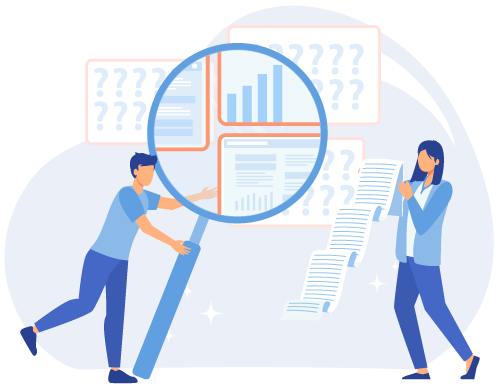






**Author:** Manish Kumar Kondoju
**Course:** – Crash Course in Forecasting
**Institution:** Northeastern University  
**Date:** November 2025



## Abstract

This notebook provides a comprehensive introduction to time series forecasting with a focus on personal health and wellness data. We explore fundamental forecasting concepts including data preparation, stationarity testing, decomposition, and various forecasting models from simple moving averages to advanced ARIMA models. Through two practical examples - predicting active days using fitness tracker data and forecasting sleep patterns - students will gain hands-on experience in preprocessing time series data, selecting appropriate models, and evaluating forecast accuracy. The material emphasizes practical applications while maintaining theoretical rigor, making it suitable for data science practitioners seeking to understand and implement forecasting solutions.

## 1. Theory Section

### 1.1 Introduction to Time Series Forecasting
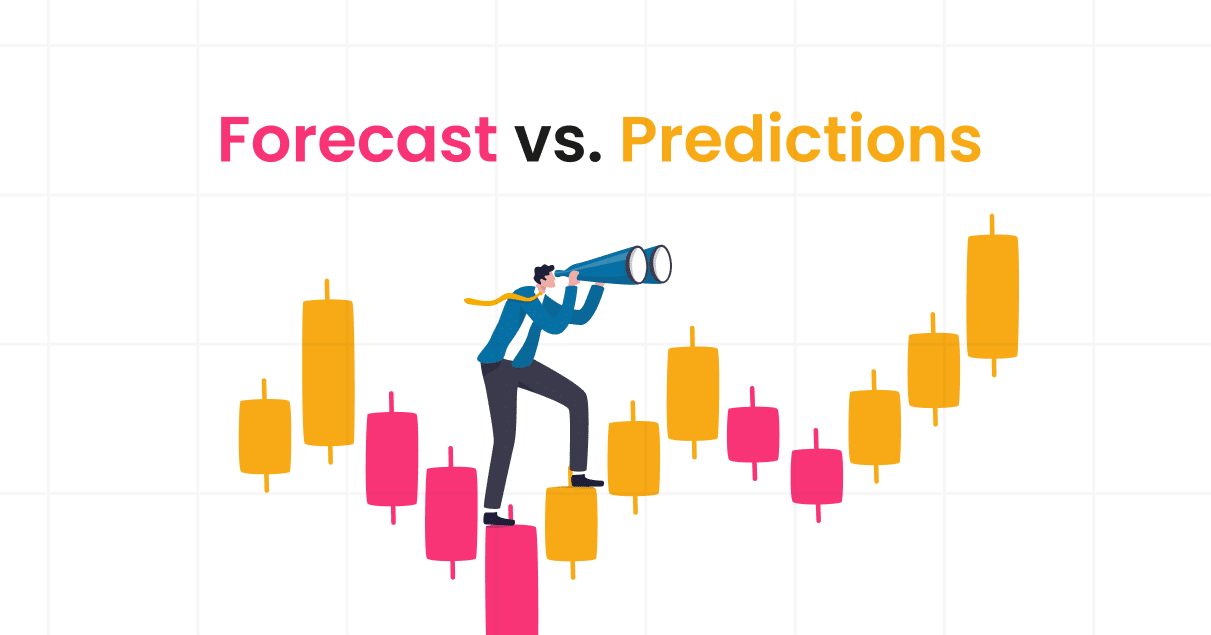
Time series forecasting is a statistical technique that uses historical data points collected over time to predict future values. Unlike cross-sectional data, time series data has a natural temporal ordering that must be preserved and leveraged for accurate predictions.

**Key Components of Time Series:**
- **Trend:** Long-term direction of the data (increasing, decreasing, or stable)
- **Seasonality:** Regular patterns that repeat at fixed intervals
- **Cyclical Patterns:** Long-term fluctuations without fixed periods
- **Irregular/Random:** Unpredictable fluctuations or noise

### 1.2 Data Preparation for Forecasting

#### 1.2.1 Handling Missing Data
Missing data in time series requires special attention as traditional methods like mean imputation can distort temporal patterns:
- **Forward Fill:** Use the last observed value
- **Backward Fill:** Use the next observed value
- **Linear Interpolation:** Estimate values based on surrounding points
- **Seasonal Interpolation:** Use values from the same season in previous periods

#### 1.2.2 Stationarity
A stationary time series has statistical properties that don't change over time:
- **Mean:** Constant over time
- **Variance:** Constant over time
- **Covariance:** Depends only on lag, not time

**Testing for Stationarity:**
- Augmented Dickey-Fuller (ADF) test
- KPSS test
- Visual inspection through rolling statistics

#### 1.2.3 Feature Engineering for Time Series
- **Lag Features:** Previous values as predictors
- **Rolling Statistics:** Moving averages and standard deviations
- **Date Features:** Hour, day of week, month, season
- **Differencing:** Computing changes between consecutive observations

### 1.3 Forecasting Models

#### 1.3.1 Simple Models
- **Naive Forecast:** Use last observed value
- **Simple Moving Average (SMA):** Average of last n periods
- **Weighted Moving Average:** Recent observations have higher weights
- **Exponential Smoothing:** Exponentially decreasing weights for older observations

#### 1.3.2 Advanced Models
- **ARIMA (AutoRegressive Integrated Moving Average):**
  - AR(p): Autoregressive component
  - I(d): Differencing order
  - MA(q): Moving average component
- **SARIMA:** ARIMA with seasonal components
- **Prophet:** Facebook's forecasting tool for handling seasonality and holidays

### 1.4 Model Evaluation

**Metrics for Forecast Accuracy:**
- **MAE (Mean Absolute Error):** Average absolute difference
- **RMSE (Root Mean Square Error):** Penalizes larger errors
- **MAPE (Mean Absolute Percentage Error):** Scale-independent metric
- **SMAPE (Symmetric MAPE):** Handles zero values better

**Cross-Validation for Time Series:**
- Time Series Split: Expanding window approach
- Rolling Window: Fixed-size training window

## 2. Setup and Imports

### 🔧 Setup: Importing Libraries

This cell imports the core libraries used throughout the notebook:
- **pandas, numpy** for data handling
- **matplotlib, seaborn** for charts
- **statsmodels** for time series analysis (ADF, KPSS, ARIMA, decomposition)
- **sklearn** for evaluation metrics and time series cross‑validation

It also sets a plotting style and random seed so your plots and results are reproducible.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Statistical and forecasting libraries
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
Pandas version: 2.2.2
NumPy version: 2.0.2


## 3. Example 1: Fitness Tracker Data - "Predicting Your Active Days"

In this example, we'll work with synthetic fitness tracker data to predict future activity levels based on historical patterns.

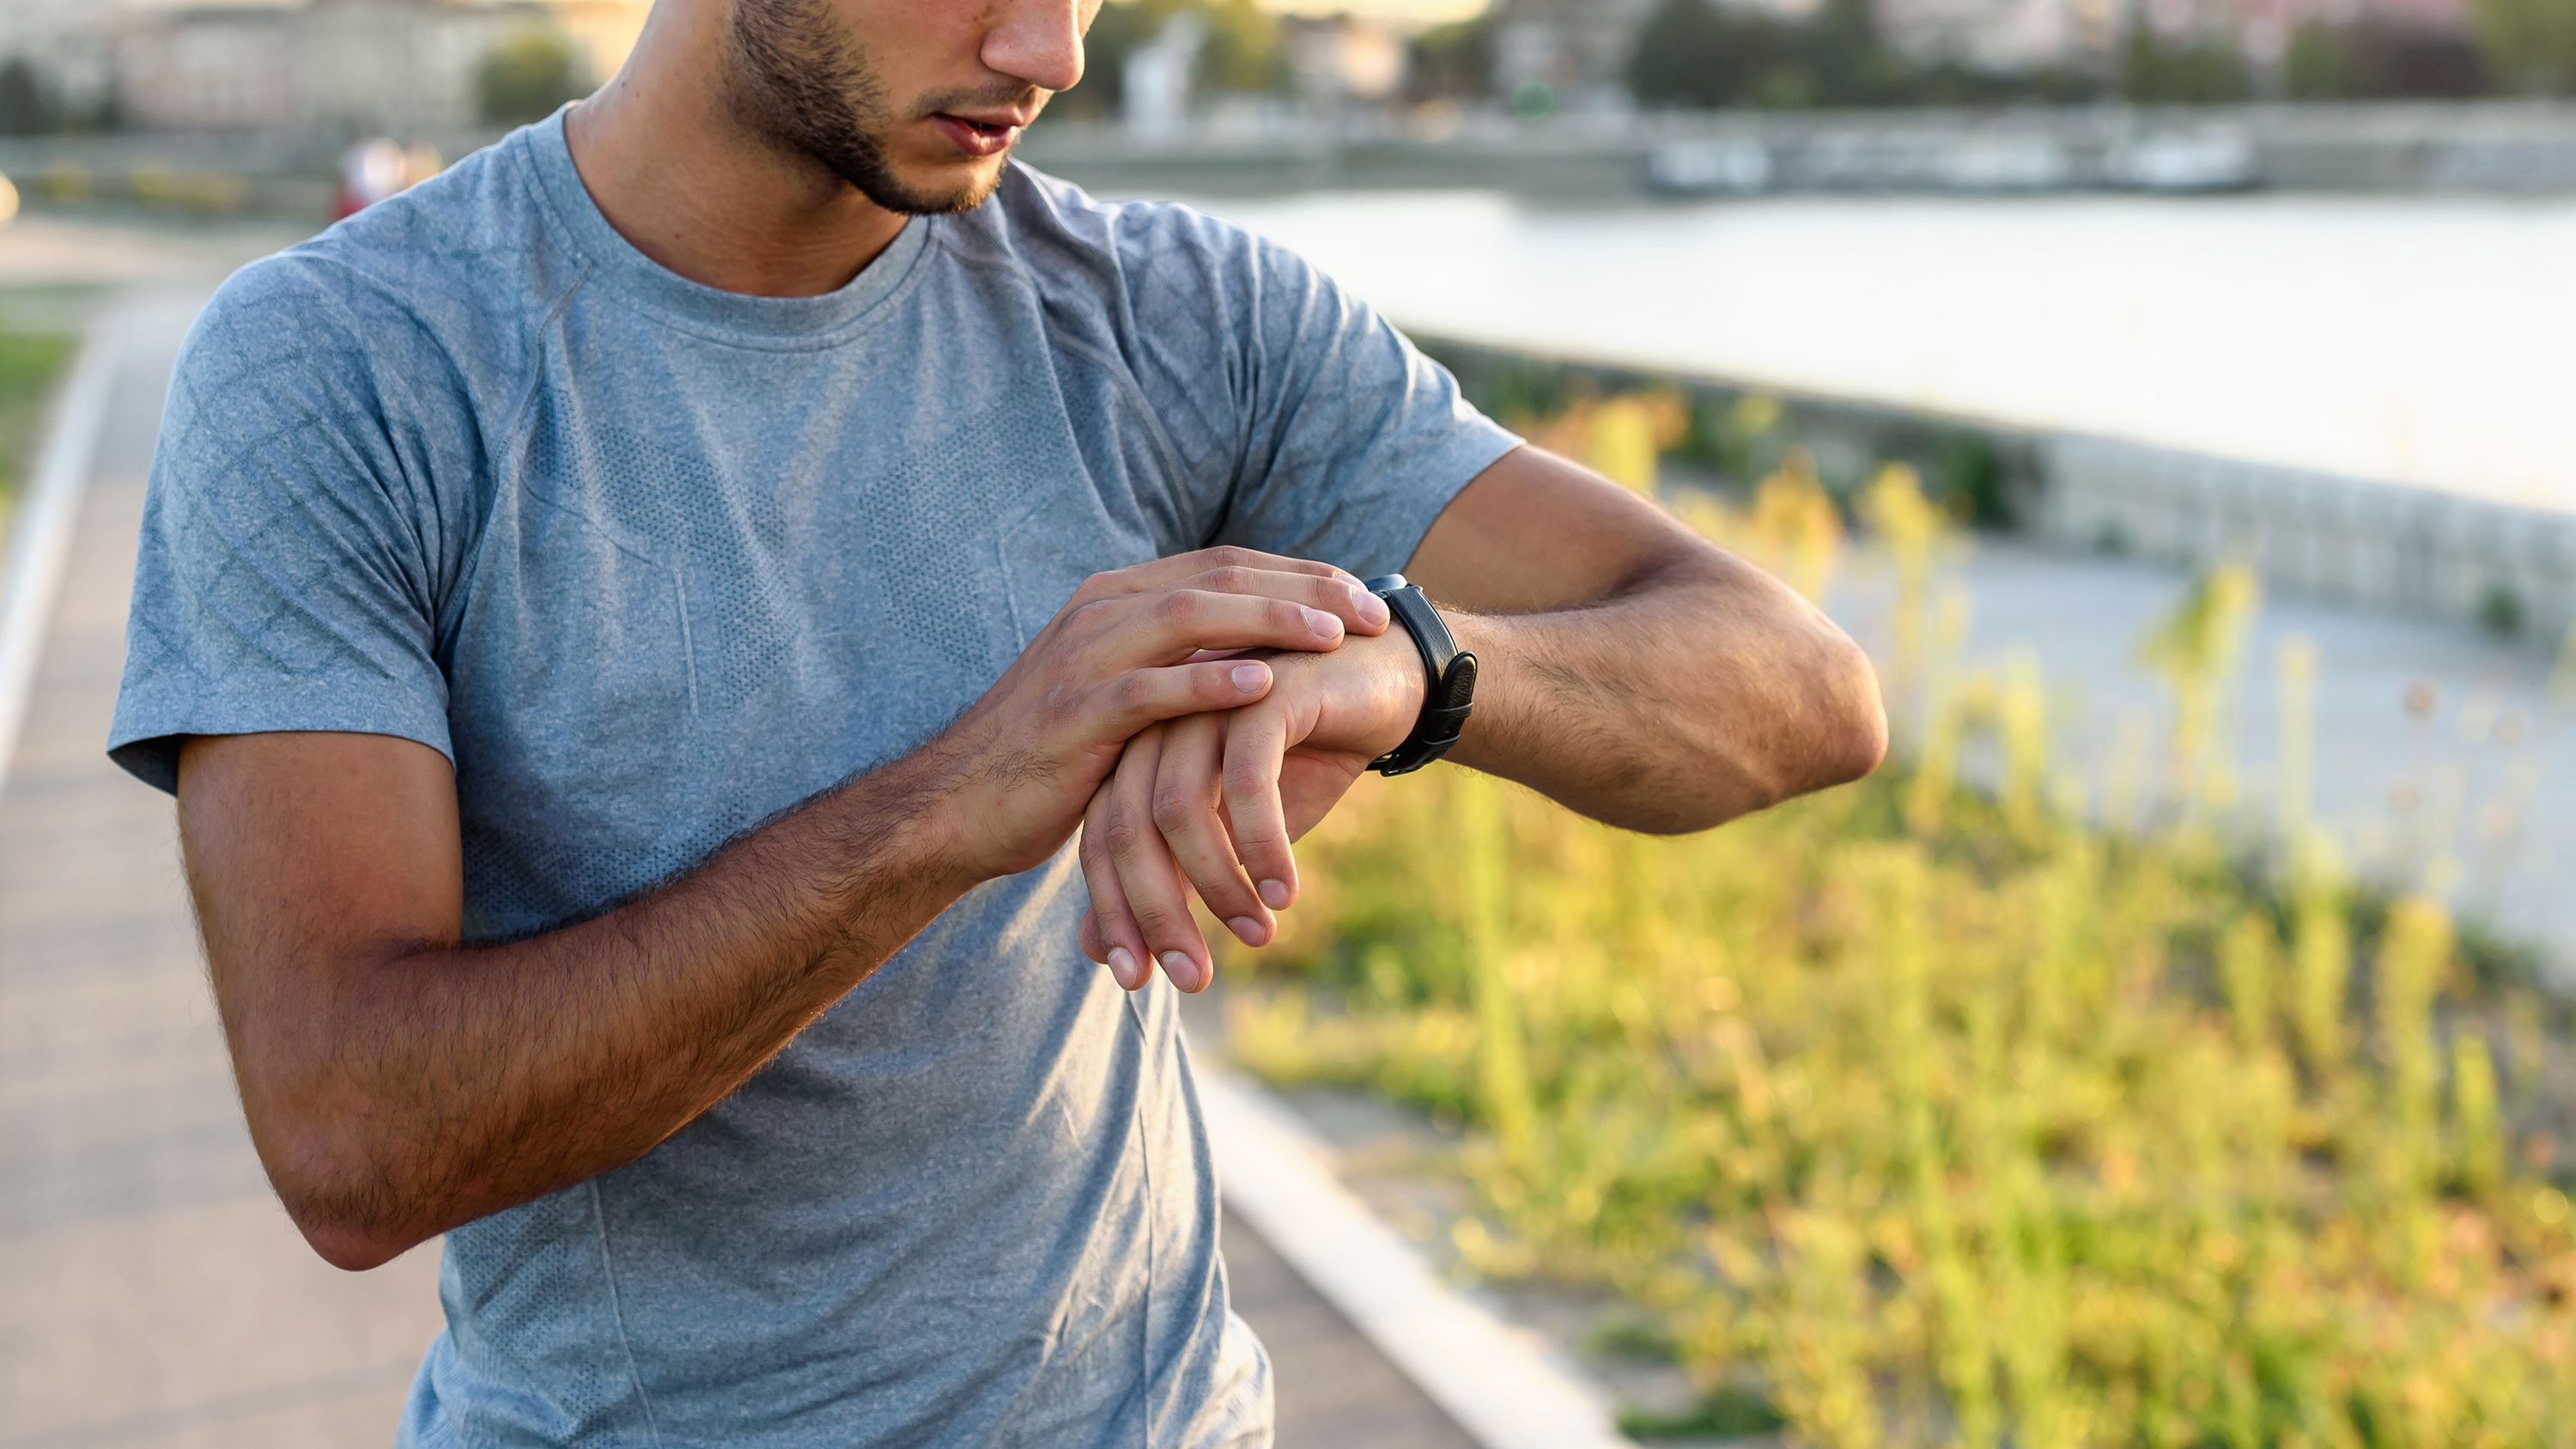

### 🏃‍♂️ Generating Synthetic Fitness Tracker Data

This function creates a **year of daily fitness data** with:
- A slowly increasing **trend** in activity
- **Weekly seasonality** (weekends are more active)
- A mild **monthly effect** and random noise
- Around 5% **missing values** to mimic real trackers

We then call this function to build `fitness_df`, the main dataset for Example 1.

In [2]:
# Generate synthetic fitness tracker data
def generate_fitness_data(start_date='2023-01-01', periods=365):
    """
    Generate synthetic fitness tracker data with realistic patterns.

    Parameters:
    -----------
    start_date : str
        Starting date for the time series
    periods : int
        Number of days to generate

    Returns:
    --------
    pd.DataFrame
        DataFrame with date index and fitness metrics
    """
    dates = pd.date_range(start=start_date, periods=periods, freq='D')

    # Base activity level with trend
    trend = np.linspace(8000, 10000, periods) + np.random.normal(0, 200, periods)

    # Weekly seasonality (more active on weekends)
    weekly_pattern = np.array([0.8, 0.9, 1.0, 1.0, 1.2, 1.3, 1.1])
    weekly_effect = np.tile(weekly_pattern, periods//7 + 1)[:periods] * 1000

    # Monthly seasonality (New Year resolution effect)
    monthly_effect = np.sin(np.arange(periods) * 2 * np.pi / 30) * 500

    # Combine all components
    steps = trend + weekly_effect + monthly_effect
    steps = np.maximum(steps, 1000)  # Minimum 1000 steps

    # Add random missing values (5% of data)
    missing_mask = np.random.random(periods) < 0.05
    steps[missing_mask] = np.nan

    # Create active minutes (correlated with steps)
    active_minutes = steps / 100 + np.random.normal(0, 5, periods)
    active_minutes[missing_mask] = np.nan
    active_minutes = np.maximum(active_minutes, 0)

    # Create DataFrame
    df = pd.DataFrame({
        'date': dates,
        'steps': steps,
        'active_minutes': active_minutes,
        'calories': steps * 0.04 + np.random.normal(300, 50, periods)
    })
    df.set_index('date', inplace=True)

    return df

# Generate the fitness data
fitness_df = generate_fitness_data()
print("Fitness Tracker Data Shape:", fitness_df.shape)
print("\nFirst 10 rows:")
fitness_df.head(10)

Fitness Tracker Data Shape: (365, 3)

First 10 rows:


,steps,active_minutes,calories
date,,,
2023-01-01,8899.342831,86.987326,676.040895
2023-01-02,8981.797491,89.784708,768.397251
2023-01-03,NaN,NaN,NaN
2023-01-04,9614.982114,100.172017,694.826754
2023-01-05,NaN,NaN,NaN
2023-01-06,9713.657838,102.538878,662.081402
2023-01-07,9924.337854,90.018852,727.907842
2023-01-08,9489.209432,89.806133,736.034599
2023-01-09,9347.322114,96.056568,822.143402


### 👀 Exploring Fitness Data Over Time

This cell performs basic **exploratory data analysis** for the fitness data:
- Plots **steps**, **active minutes**, and **calories** across the year
- Prints summary statistics and counts missing values

Use these plots to visually inspect trends, seasonality, and outliers before modeling.

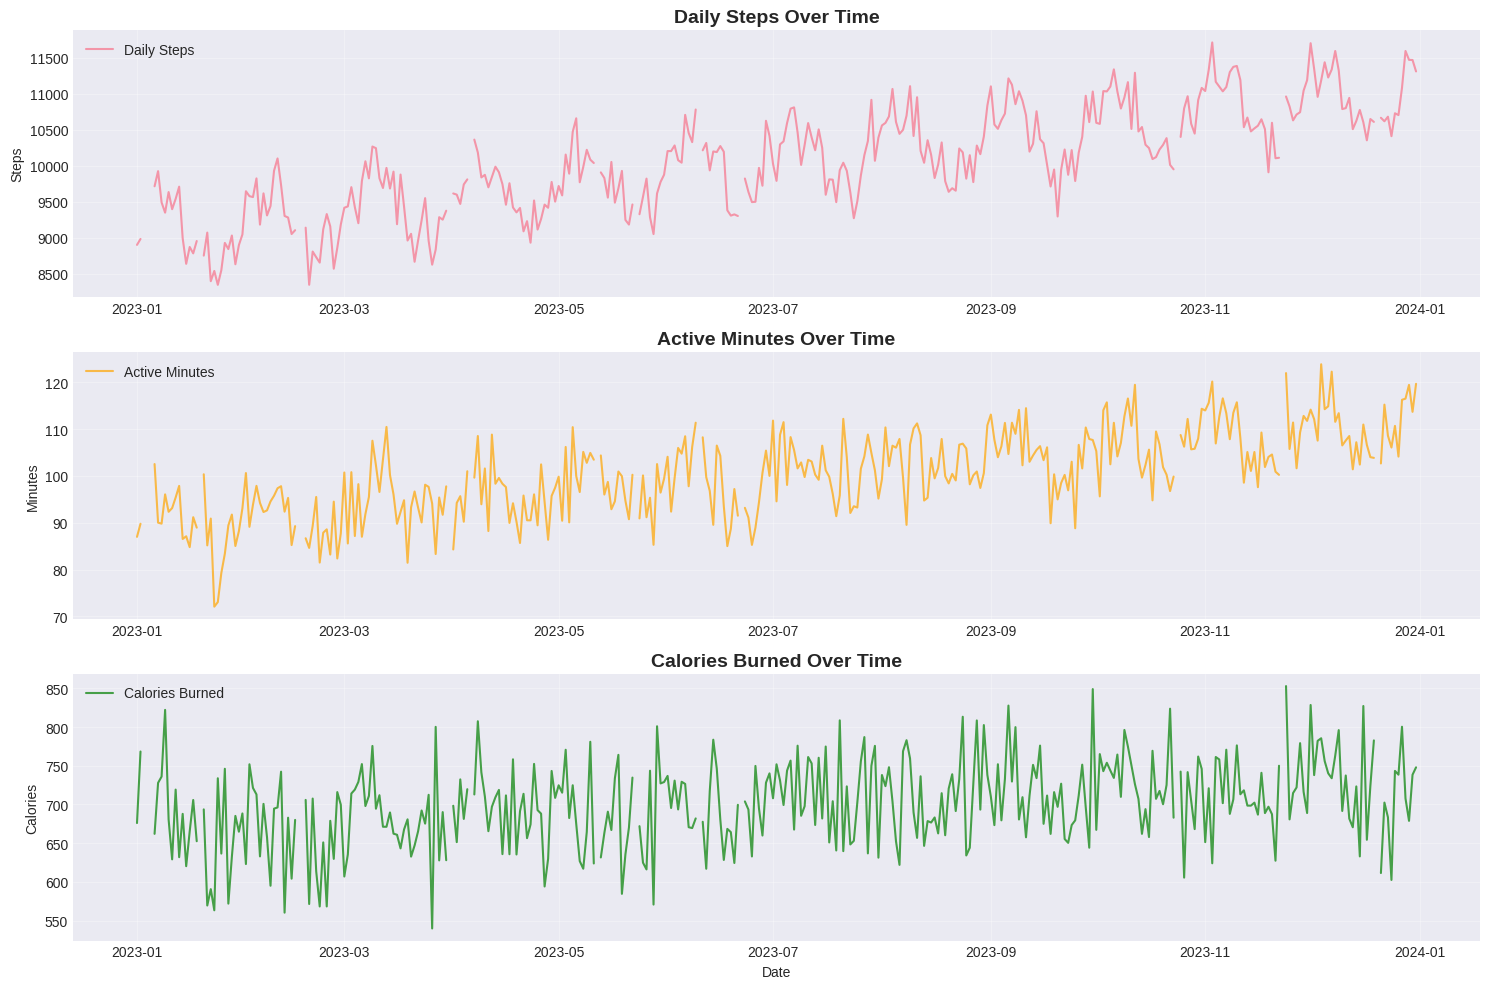


Summary Statistics:
              steps  active_minutes    calories
count    351.000000      351.000000  351.000000
mean   10056.978662      100.351750  700.267232
std      723.797413        8.937707   55.327520
min     8344.163041       72.074481  539.926516
25%     9527.566309       94.237440  665.111862
50%    10051.745123      100.279605  699.708838
75%    10595.940510      106.578299  738.008625
max    11712.379919      123.856453  852.879832

Missing Values:
steps             14
active_minutes    14
calories          14
dtype: int64


In [3]:
# Data exploration and visualization
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Plot steps over time
axes[0].plot(fitness_df.index, fitness_df['steps'], label='Daily Steps', alpha=0.7)
axes[0].set_title('Daily Steps Over Time', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Steps')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot active minutes
axes[1].plot(fitness_df.index, fitness_df['active_minutes'],
             label='Active Minutes', color='orange', alpha=0.7)
axes[1].set_title('Active Minutes Over Time', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Minutes')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot calories burned
axes[2].plot(fitness_df.index, fitness_df['calories'],
             label='Calories Burned', color='green', alpha=0.7)
axes[2].set_title('Calories Burned Over Time', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Calories')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nSummary Statistics:")
print(fitness_df.describe())
print("\nMissing Values:")
print(fitness_df.isnull().sum())

### 3.1 Data Preprocessing

### 🧹 Handling Missing Values in Time Series

Here we define `handle_missing_values`, a helper to fill gaps in a time series using:
- **Linear interpolation**
- **Forward fill / backward fill**
- **Mean imputation**

We then use interpolation to clean `steps` and `active_minutes` and compare different strategies on a small slice of data.

Missing values after cleaning:
steps_clean             0
active_minutes_clean    0
dtype: int64


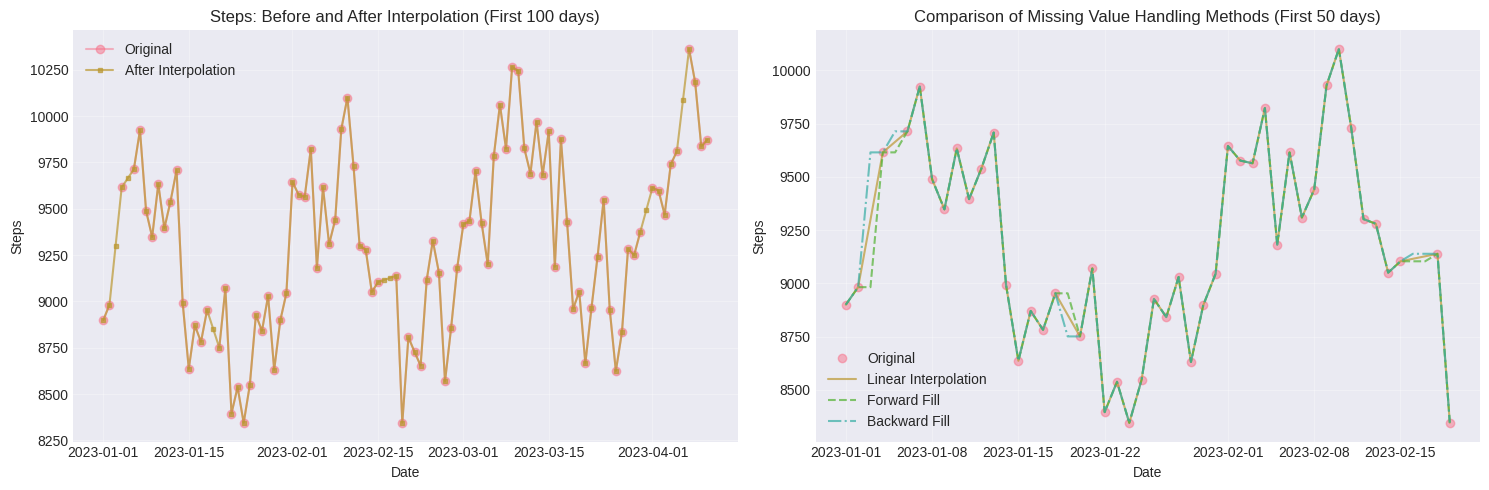

In [4]:
# Handle missing values using different strategies
def handle_missing_values(df, column, method='interpolate'):
    """
    Handle missing values in time series data.

    Parameters:
    -----------
    df : pd.DataFrame
        Input DataFrame
    column : str
        Column name to process
    method : str
        Method for handling missing values ('interpolate', 'forward', 'backward', 'mean')

    Returns:
    --------
    pd.Series
        Series with missing values handled
    """
    if method == 'interpolate':
        return df[column].interpolate(method='linear')
    elif method == 'forward':
        return df[column].fillna(method='ffill')
    elif method == 'backward':
        return df[column].fillna(method='bfill')
    elif method == 'mean':
        return df[column].fillna(df[column].mean())
    else:
        raise ValueError(f"Unknown method: {method}")

# Apply interpolation to handle missing values
fitness_df['steps_clean'] = handle_missing_values(fitness_df, 'steps', 'interpolate')
fitness_df['active_minutes_clean'] = handle_missing_values(fitness_df, 'active_minutes', 'interpolate')

print("Missing values after cleaning:")
print(fitness_df[['steps_clean', 'active_minutes_clean']].isnull().sum())

# Visualize the effect of interpolation
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Before and after for steps
axes[0].plot(fitness_df.index[:100], fitness_df['steps'][:100],
             'o-', label='Original', alpha=0.5)
axes[0].plot(fitness_df.index[:100], fitness_df['steps_clean'][:100],
             's-', label='After Interpolation', alpha=0.7, markersize=3)
axes[0].set_title('Steps: Before and After Interpolation (First 100 days)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Steps')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Comparison of interpolation methods
methods_comparison = pd.DataFrame({
    'Original': fitness_df['steps'][:50],
    'Linear': handle_missing_values(fitness_df[:50], 'steps', 'interpolate'),
    'Forward Fill': handle_missing_values(fitness_df[:50], 'steps', 'forward'),
    'Backward Fill': handle_missing_values(fitness_df[:50], 'steps', 'backward')
})

axes[1].plot(methods_comparison.index, methods_comparison['Original'],
             'o', label='Original', alpha=0.5)
axes[1].plot(methods_comparison.index, methods_comparison['Linear'],
             '-', label='Linear Interpolation', alpha=0.7)
axes[1].plot(methods_comparison.index, methods_comparison['Forward Fill'],
             '--', label='Forward Fill', alpha=0.7)
axes[1].plot(methods_comparison.index, methods_comparison['Backward Fill'],
             '-.', label='Backward Fill', alpha=0.7)
axes[1].set_title('Comparison of Missing Value Handling Methods (First 50 days)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Steps')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.2 Stationarity Testing and Transformation

### 📏 Testing Stationarity (ADF & KPSS)

Many classical forecasting models (like ARIMA) assume a **stationary series**.
This helper function:
- Plots **rolling mean and standard deviation** (30‑day window)
- Runs the **ADF test** (null: non‑stationary)
- Runs the **KPSS test** (null: stationary)

Combining both tests gives a more reliable sense of whether transformation is needed.

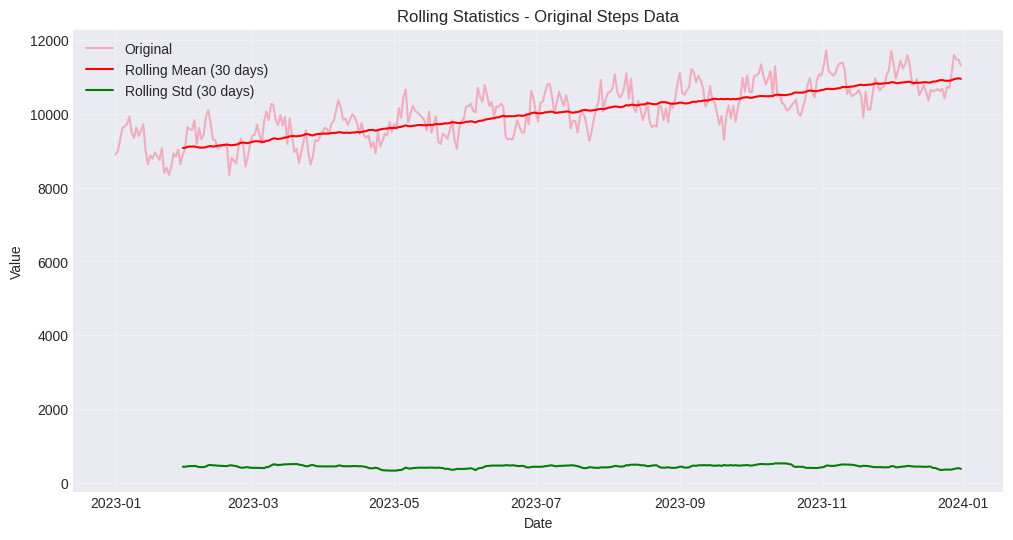


Original Steps Data - Augmented Dickey-Fuller Test:
ADF Statistic: -0.9159
p-value: 0.7827
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
Result: Series is non-stationary (fail to reject H0)

Original Steps Data - KPSS Test:
KPSS Statistic: 2.5627
p-value: 0.0100
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Result: Series is non-stationary (reject H0)


/tmp/ipython-input-2352385248.py:45: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries.dropna(), regression='c')


In [5]:
def test_stationarity(timeseries, title='Time Series'):
    """
    Test for stationarity using ADF and KPSS tests.
    Visualize rolling statistics.

    Parameters:
    -----------
    timeseries : pd.Series
        Time series to test
    title : str
        Title for the plot
    """
    # Calculate rolling statistics
    rolling_mean = timeseries.rolling(window=30).mean()
    rolling_std = timeseries.rolling(window=30).std()

    # Plot rolling statistics
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(timeseries, label='Original', alpha=0.5)
    ax.plot(rolling_mean, color='red', label='Rolling Mean (30 days)')
    ax.plot(rolling_std, color='green', label='Rolling Std (30 days)')
    ax.set_title(f'Rolling Statistics - {title}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    plt.show()

    # Perform ADF test
    print(f'\n{title} - Augmented Dickey-Fuller Test:')
    adf_result = adfuller(timeseries.dropna())
    print(f'ADF Statistic: {adf_result[0]:.4f}')
    print(f'p-value: {adf_result[1]:.4f}')
    print(f'Critical Values:')
    for key, value in adf_result[4].items():
        print(f'\t{key}: {value:.3f}')

    if adf_result[1] <= 0.05:
        print("Result: Series is stationary (reject H0)")
    else:
        print("Result: Series is non-stationary (fail to reject H0)")

    # Perform KPSS test
    print(f'\n{title} - KPSS Test:')
    kpss_result = kpss(timeseries.dropna(), regression='c')
    print(f'KPSS Statistic: {kpss_result[0]:.4f}')
    print(f'p-value: {kpss_result[1]:.4f}')
    print(f'Critical Values:')
    for key, value in kpss_result[3].items():
        print(f'\t{key}: {value:.3f}')

    if kpss_result[1] >= 0.05:
        print("Result: Series is stationary (fail to reject H0)")
    else:
        print("Result: Series is non-stationary (reject H0)")

# Test original series
test_stationarity(fitness_df['steps_clean'], 'Original Steps Data')

### 👀 Exploring Fitness Data Over Time

This cell performs basic **exploratory data analysis** for the fitness data:
- Plots **steps**, **active minutes**, and **calories** across the year
- Prints summary statistics and counts missing values

Use these plots to visually inspect trends, seasonality, and outliers before modeling.

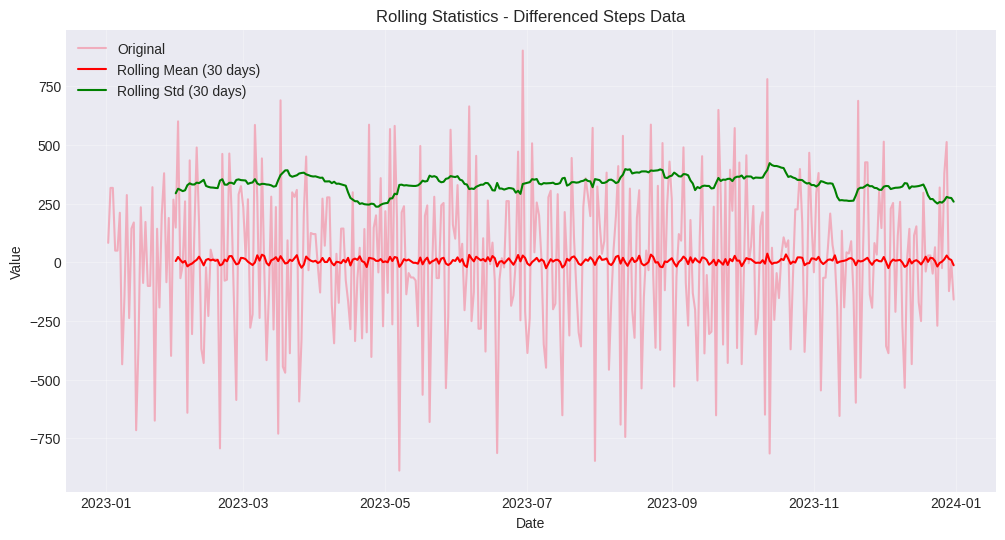


Differenced Steps Data - Augmented Dickey-Fuller Test:
ADF Statistic: -9.5565
p-value: 0.0000
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
Result: Series is stationary (reject H0)

Differenced Steps Data - KPSS Test:
KPSS Statistic: 0.0110
p-value: 0.1000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Result: Series is stationary (fail to reject H0)


/tmp/ipython-input-2352385248.py:45: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(timeseries.dropna(), regression='c')


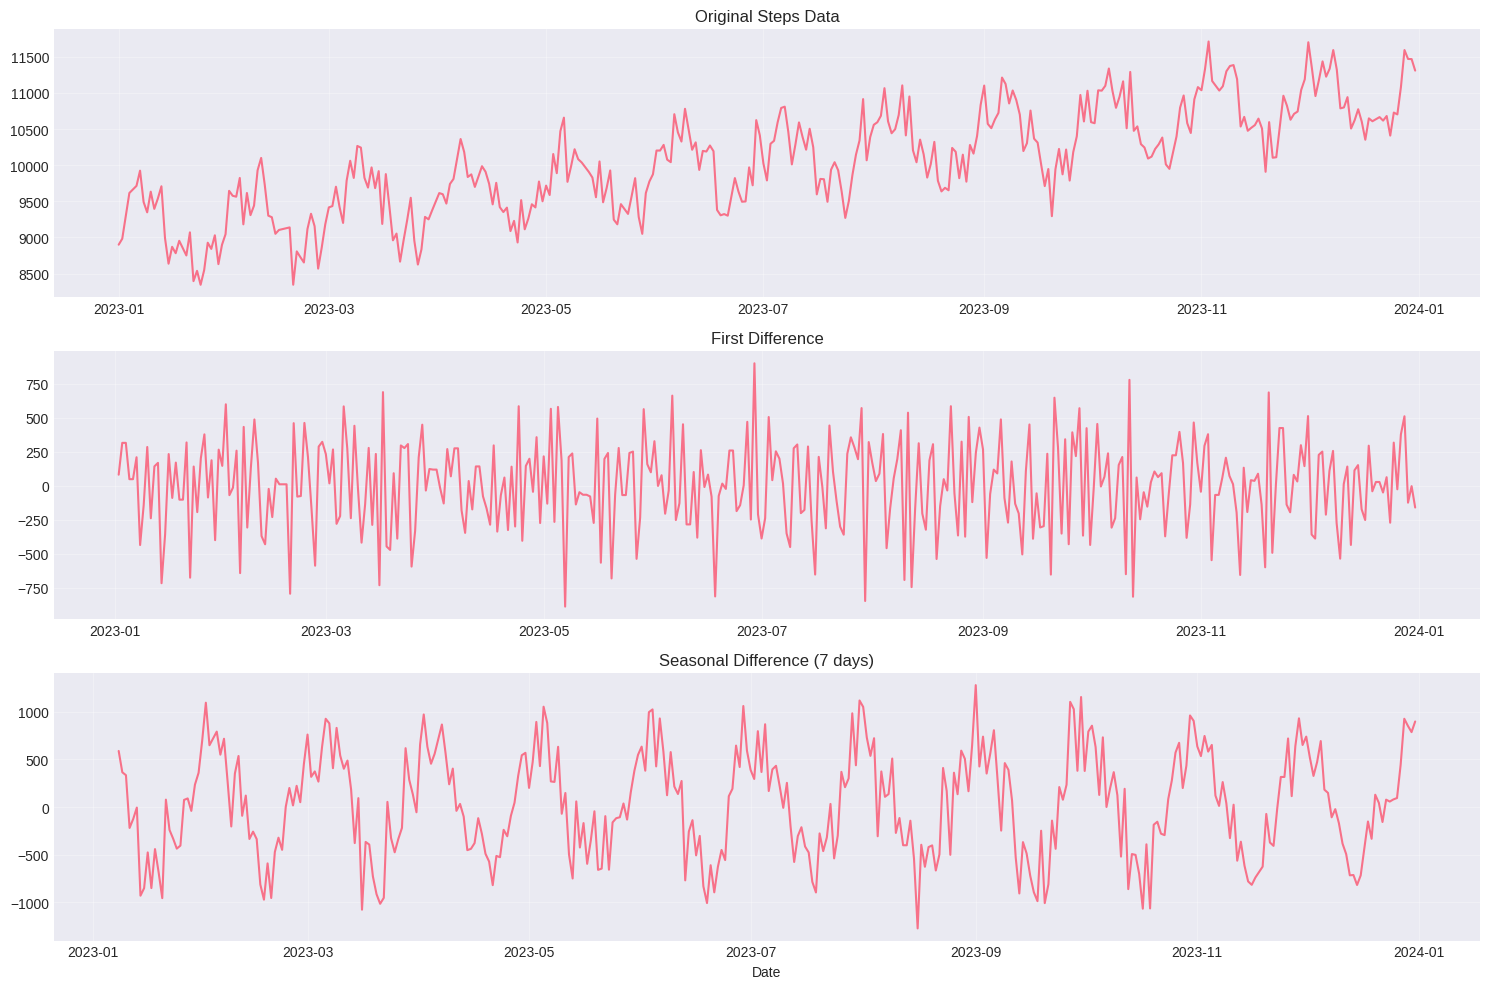

In [6]:
# Apply differencing to make series stationary
fitness_df['steps_diff'] = fitness_df['steps_clean'].diff()

# Test differenced series
test_stationarity(fitness_df['steps_diff'].dropna(), 'Differenced Steps Data')

# Seasonal differencing (weekly)
fitness_df['steps_seasonal_diff'] = fitness_df['steps_clean'].diff(7)

# Visualize different transformations
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

axes[0].plot(fitness_df['steps_clean'])
axes[0].set_title('Original Steps Data')
axes[0].grid(True, alpha=0.3)

axes[1].plot(fitness_df['steps_diff'])
axes[1].set_title('First Difference')
axes[1].grid(True, alpha=0.3)

axes[2].plot(fitness_df['steps_seasonal_diff'])
axes[2].set_title('Seasonal Difference (7 days)')
axes[2].set_xlabel('Date')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.3 Time Series Decomposition

### 🔍 Decomposing the Steps Series

Using `seasonal_decompose`, we split the steps time series into:
- **Trend**
- **Seasonal component** (weekly)
- **Residual (noise)**

This reveals how much of the observed behavior is systematic vs. random, which informs model choice.

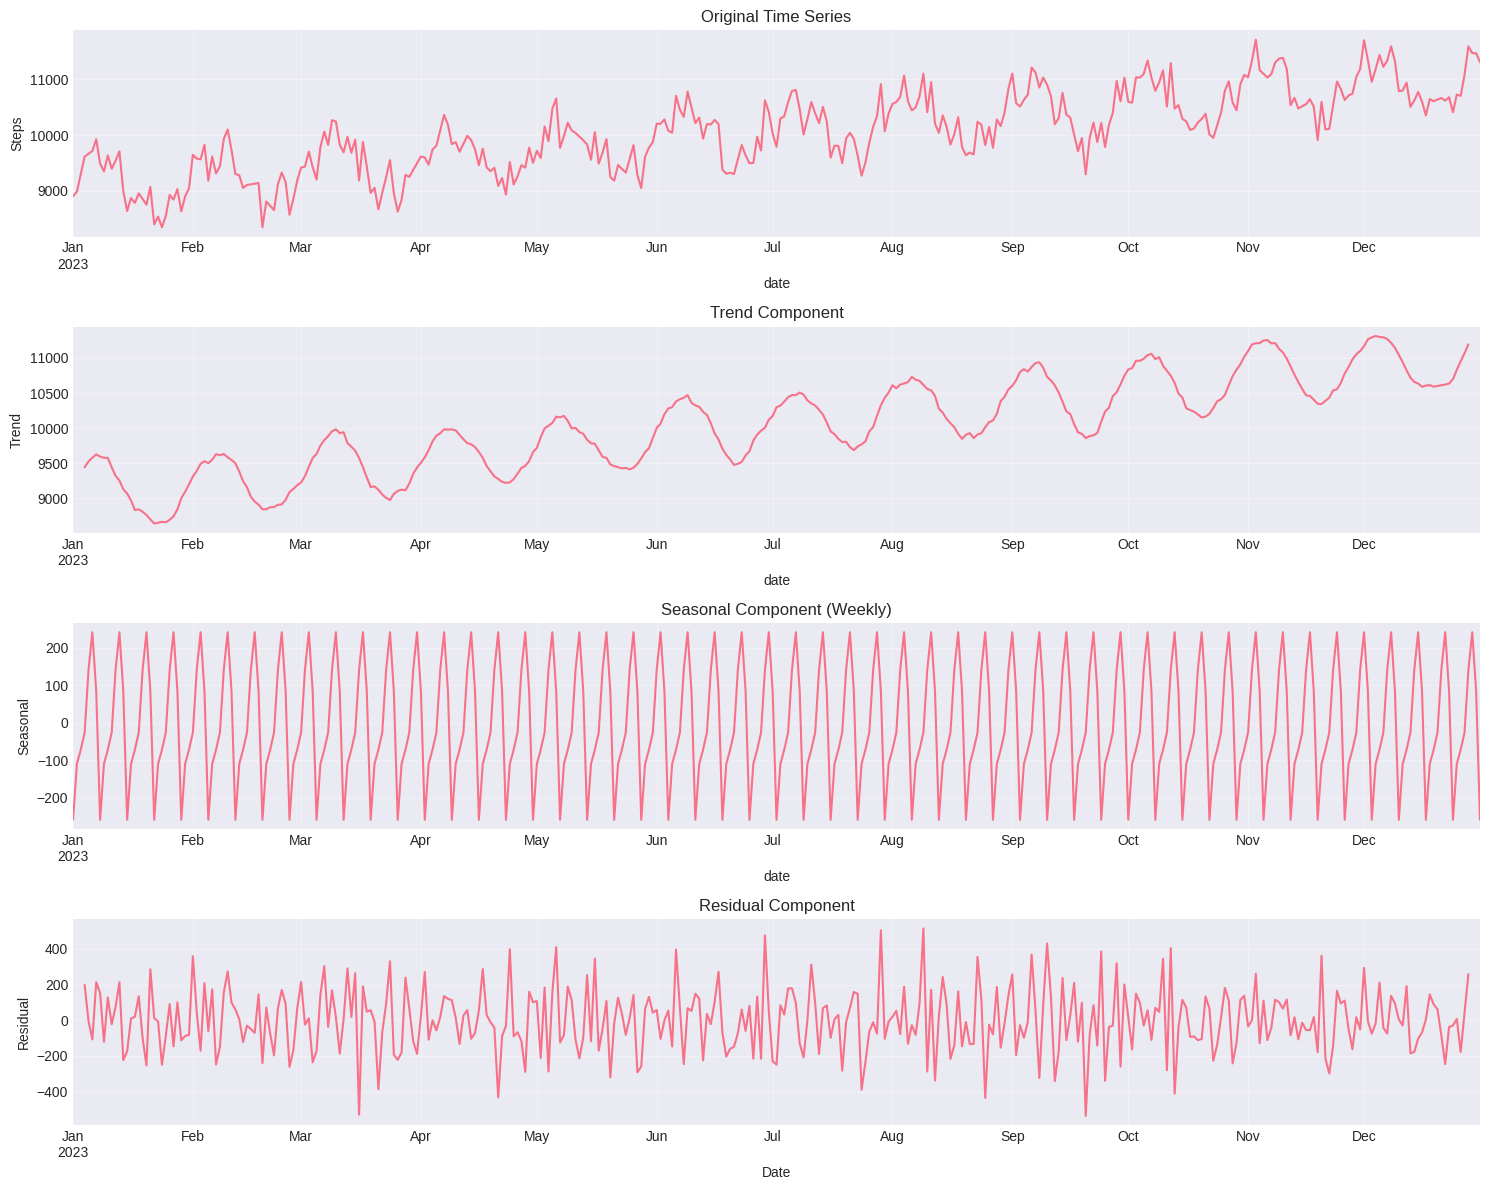


Weekly Seasonal Pattern:
Monday: -259.2 steps
Tuesday: -109.9 steps
Wednesday: -71.9 steps
Thursday: -26.1 steps
Friday: +141.3 steps
Saturday: +241.9 steps
Sunday: +83.9 steps


In [7]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(fitness_df['steps_clean'], model='additive', period=7)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

fitness_df['steps_clean'].plot(ax=axes[0], title='Original Time Series')
axes[0].set_ylabel('Steps')
axes[0].grid(True, alpha=0.3)

decomposition.trend.plot(ax=axes[1], title='Trend Component')
axes[1].set_ylabel('Trend')
axes[1].grid(True, alpha=0.3)

decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component (Weekly)')
axes[2].set_ylabel('Seasonal')
axes[2].grid(True, alpha=0.3)

decomposition.resid.plot(ax=axes[3], title='Residual Component')
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze seasonal patterns
print("\nWeekly Seasonal Pattern:")
weekly_pattern = decomposition.seasonal[:7].values
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for day, value in zip(days, weekly_pattern):
    print(f"{day}: {value:+.1f} steps")

### 3.4 Feature Engineering

### 🧩 Feature Engineering for Time‑Based Patterns

This function enriches the fitness dataset with:
- Calendar features: day of week, month, quarter, weekend flags, month start/end
- **Lag features** (1, 7, 14, 30 days)
- **Rolling means/standard deviations** (7, 14, 30 days)
- **Exponential weighted means**

These features are useful when building machine‑learning style models for forecasting.

Feature Engineering Complete!
Total features created: 20

New feature columns:
['day_of_week', 'day_of_month', 'week_of_year', 'month', 'quarter', 'is_weekend', 'is_month_start', 'is_month_end', 'steps_lag_1', 'steps_lag_7'] ...


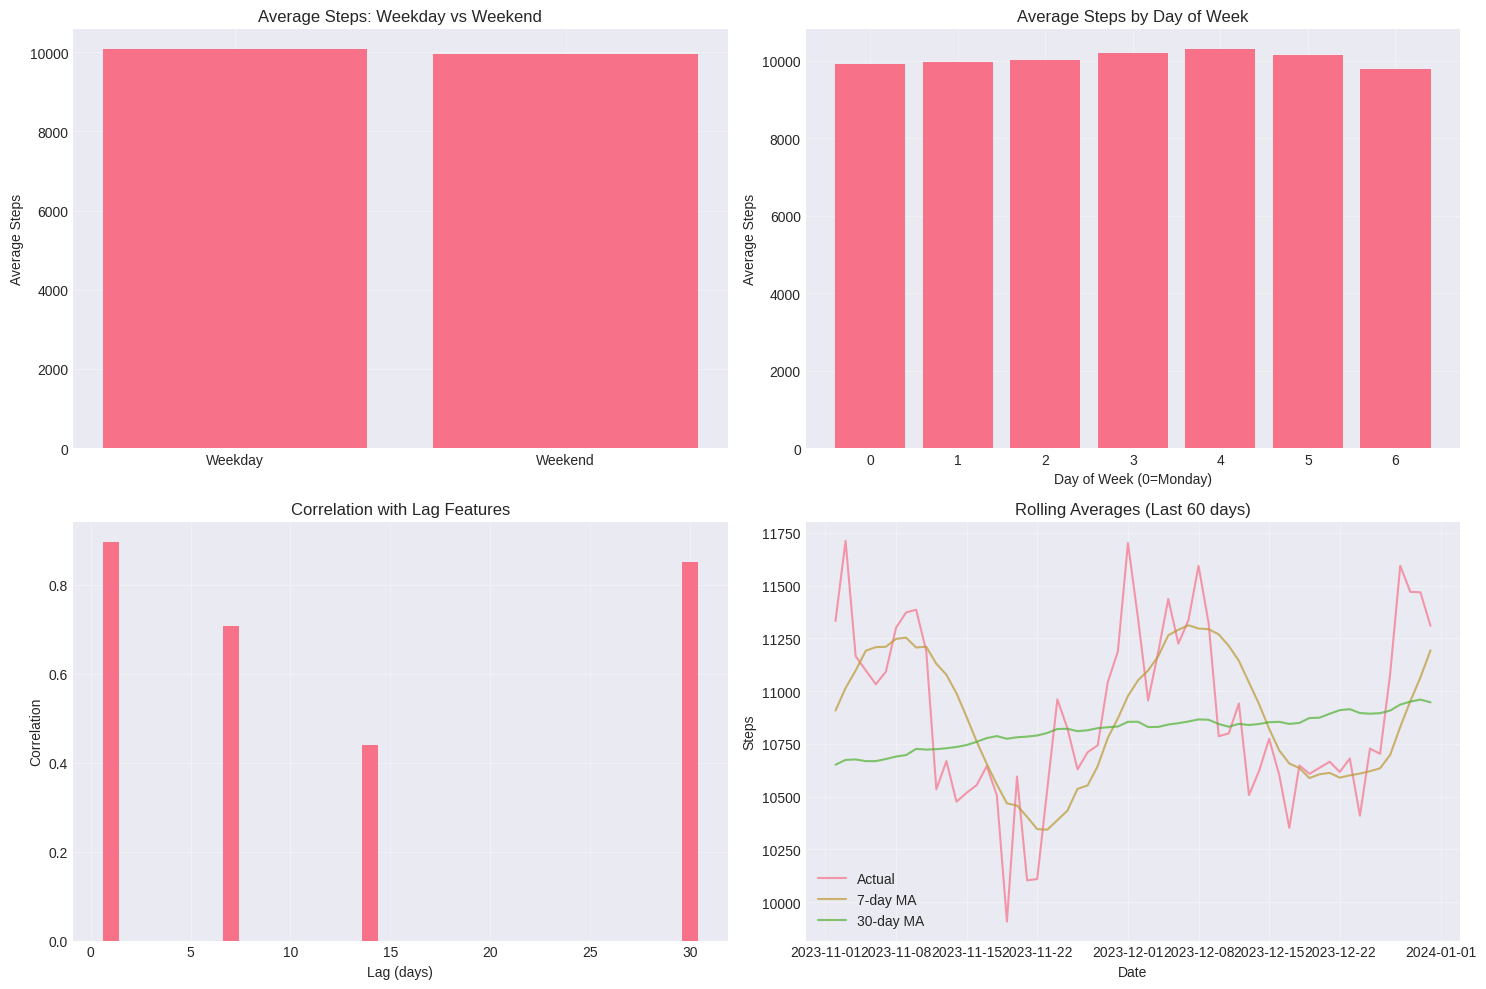

In [8]:
def create_time_features(df):
    """
    Create time-based features for forecasting.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with datetime index

    Returns:
    --------
    pd.DataFrame
        DataFrame with additional time features
    """
    df = df.copy()

    # Basic time features
    df['day_of_week'] = df.index.dayofweek
    df['day_of_month'] = df.index.day
    df['week_of_year'] = df.index.isocalendar().week
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter

    # Binary features
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['is_month_start'] = df.index.is_month_start.astype(int)
    df['is_month_end'] = df.index.is_month_end.astype(int)

    # Lag features
    for lag in [1, 7, 14, 30]:
        df[f'steps_lag_{lag}'] = df['steps_clean'].shift(lag)

    # Rolling statistics
    for window in [7, 14, 30]:
        df[f'steps_roll_mean_{window}'] = df['steps_clean'].rolling(window=window).mean()
        df[f'steps_roll_std_{window}'] = df['steps_clean'].rolling(window=window).std()

    # Exponential weighted moving average
    df['steps_ewm_7'] = df['steps_clean'].ewm(span=7).mean()
    df['steps_ewm_30'] = df['steps_clean'].ewm(span=30).mean()

    return df

# Create features
fitness_features = create_time_features(fitness_df)

print("Feature Engineering Complete!")
print(f"Total features created: {len(fitness_features.columns) - len(fitness_df.columns)}")
print("\nNew feature columns:")
new_features = [col for col in fitness_features.columns if col not in fitness_df.columns]
print(new_features[:10], "...")

# Visualize some engineered features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Weekend effect
weekend_avg = fitness_features.groupby('is_weekend')['steps_clean'].mean()
axes[0, 0].bar(['Weekday', 'Weekend'], weekend_avg.values)
axes[0, 0].set_title('Average Steps: Weekday vs Weekend')
axes[0, 0].set_ylabel('Average Steps')
axes[0, 0].grid(True, alpha=0.3)

# Day of week pattern
dow_avg = fitness_features.groupby('day_of_week')['steps_clean'].mean()
axes[0, 1].bar(range(7), dow_avg.values)
axes[0, 1].set_title('Average Steps by Day of Week')
axes[0, 1].set_xlabel('Day of Week (0=Monday)')
axes[0, 1].set_ylabel('Average Steps')
axes[0, 1].grid(True, alpha=0.3)

# Lag correlation
lag_corr = [fitness_features[['steps_clean', f'steps_lag_{lag}']].corr().iloc[0, 1]
            for lag in [1, 7, 14, 30]]
axes[1, 0].bar([1, 7, 14, 30], lag_corr)
axes[1, 0].set_title('Correlation with Lag Features')
axes[1, 0].set_xlabel('Lag (days)')
axes[1, 0].set_ylabel('Correlation')
axes[1, 0].grid(True, alpha=0.3)

# Rolling mean comparison
axes[1, 1].plot(fitness_features.index[-60:],
                fitness_features['steps_clean'][-60:],
                label='Actual', alpha=0.7)
axes[1, 1].plot(fitness_features.index[-60:],
                fitness_features['steps_roll_mean_7'][-60:],
                label='7-day MA', alpha=0.7)
axes[1, 1].plot(fitness_features.index[-60:],
                fitness_features['steps_roll_mean_30'][-60:],
                label='30-day MA', alpha=0.7)
axes[1, 1].set_title('Rolling Averages (Last 60 days)')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Steps')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.5 ARIMA Model Building and Forecasting

### ✂️ Train–Test Split for Steps Forecasting

The cleaned `steps_clean` series is split into:
- **Training set (first 80%)** to fit the ARIMA model
- **Test set (last 20%)** to evaluate how well forecasts generalize

We also print the date ranges to clearly see which period is used for training vs. testing.

In [9]:
# Split data into train and test sets
train_size = int(len(fitness_df) * 0.8)
train_data = fitness_df['steps_clean'][:train_size]
test_data = fitness_df['steps_clean'][train_size:]

print(f"Training set size: {len(train_data)} days")
print(f"Test set size: {len(test_data)} days")
print(f"Training period: {train_data.index[0].date()} to {train_data.index[-1].date()}")
print(f"Test period: {test_data.index[0].date()} to {test_data.index[-1].date()}")

Training set size: 292 days
Test set size: 73 days
Training period: 2023-01-01 to 2023-10-19
Test period: 2023-10-20 to 2023-12-31


### 📊 ACF & PACF for Choosing AR and MA Orders

This cell displays:
- The **Autocorrelation Function (ACF)**: correlation with past lags
- The **Partial Autocorrelation Function (PACF)**: direct effect of specific lags

These plots help you guess reasonable ARIMA orders `(p, d, q)` before running a grid search.

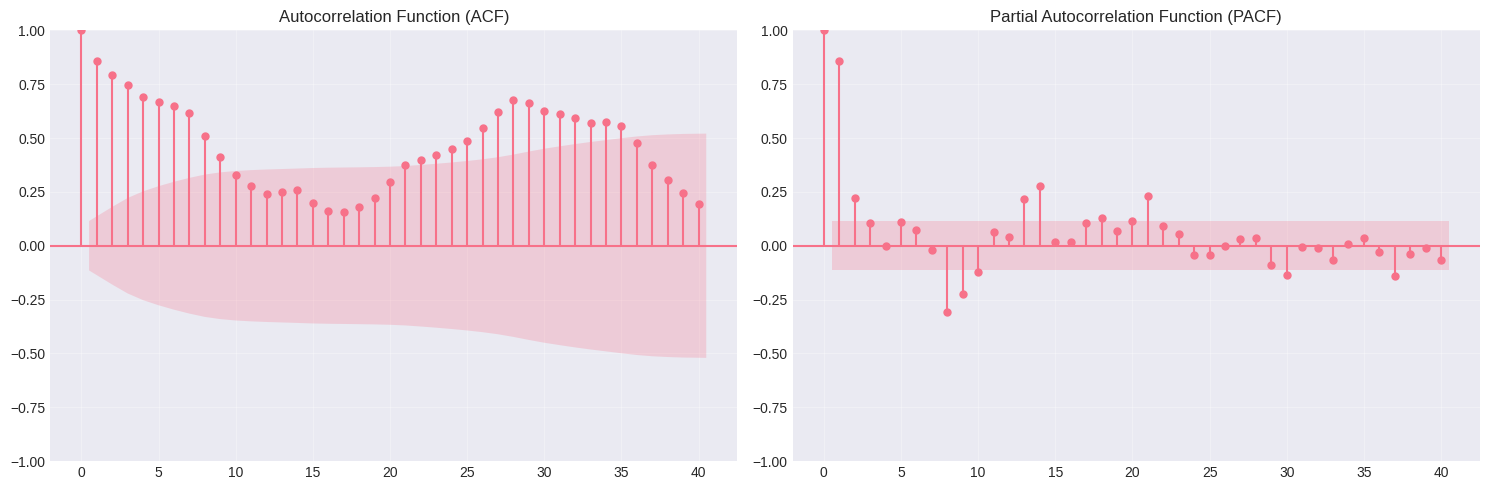

In [10]:
# ACF and PACF plots to determine ARIMA parameters
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ACF plot
plot_acf(train_data.dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')
axes[0].grid(True, alpha=0.3)

# PACF plot
plot_pacf(train_data.dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 🔎 Grid Search for Best ARIMA(p,d,q)

Here we loop over small ranges of `(p, d, q)` and for each combination:
- Fit an ARIMA model on the training data
- Forecast the test horizon
- Compute **RMSE** and track the best‑performing configuration

This is a simple but effective way to tune ARIMA parameters for the steps series.

In [11]:
# Grid search for best ARIMA parameters
def evaluate_arima_model(train_data, test_data, arima_order):
    """
    Evaluate ARIMA model with given parameters.

    Parameters:
    -----------
    train_data : pd.Series
        Training data
    test_data : pd.Series
        Test data
    arima_order : tuple
        (p, d, q) parameters for ARIMA

    Returns:
    --------
    float
        RMSE on test set
    """
    try:
        model = ARIMA(train_data, order=arima_order)
        model_fit = model.fit()
        predictions = model_fit.forecast(steps=len(test_data))
        rmse = np.sqrt(mean_squared_error(test_data, predictions))
        return rmse
    except:
        return float('inf')

# Grid search
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

best_rmse = float('inf')
best_order = None

print("Searching for best ARIMA parameters...")
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            rmse = evaluate_arima_model(train_data, test_data, order)
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = order
                print(f"New best order: {order} with RMSE: {rmse:.2f}")

print(f"\nBest ARIMA order: {best_order}")
print(f"Best RMSE: {best_rmse:.2f}")

Searching for best ARIMA parameters...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


New best order: (0, 0, 0) with RMSE: 1078.13


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


New best order: (0, 0, 1) with RMSE: 1077.82


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


New best order: (0, 0, 2) with RMSE: 1076.79
New best order: (0, 1, 0) with RMSE: 746.52


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat


Best ARIMA order: (0, 1, 0)
Best RMSE: 746.52


### 📈 Fitting the Final ARIMA Model and Evaluating It

Using the best `(p, d, q)` from grid search, this cell:
- Fits the final ARIMA model
- Forecasts the test period
- Calculates **MAE**, **RMSE**, and **MAPE** for forecast accuracy

These metrics tell you how well the model predicts step counts on unseen days.

In [12]:
# Train final ARIMA model with best parameters
final_model = ARIMA(train_data, order=best_order)
final_model_fit = final_model.fit()

# Print model summary
print(final_model_fit.summary())

# Make predictions
predictions = final_model_fit.forecast(steps=len(test_data))
predictions.index = test_data.index

# Calculate metrics
mae = mean_absolute_error(test_data, predictions)
rmse = np.sqrt(mean_squared_error(test_data, predictions))
mape = np.mean(np.abs((test_data - predictions) / test_data)) * 100

print(f"\nForecast Performance Metrics:")
print(f"MAE: {mae:.2f} steps")
print(f"RMSE: {rmse:.2f} steps")
print(f"MAPE: {mape:.2f}%")

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            steps_clean   No. Observations:                  292
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2105.532
Date:                Fri, 21 Nov 2025   AIC                           4213.064
Time:                        02:40:57   BIC                           4216.737
Sample:                    01-01-2023   HQIC                          4214.535
                         - 10-19-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.131e+05   1.01e+04     11.215      0.000    9.33e+04    1.33e+05
Ljung-Box (L1) (Q):                  23.72   Jarque-Bera (JB):                 3.92
Prob(Q):                              0.00   Pr

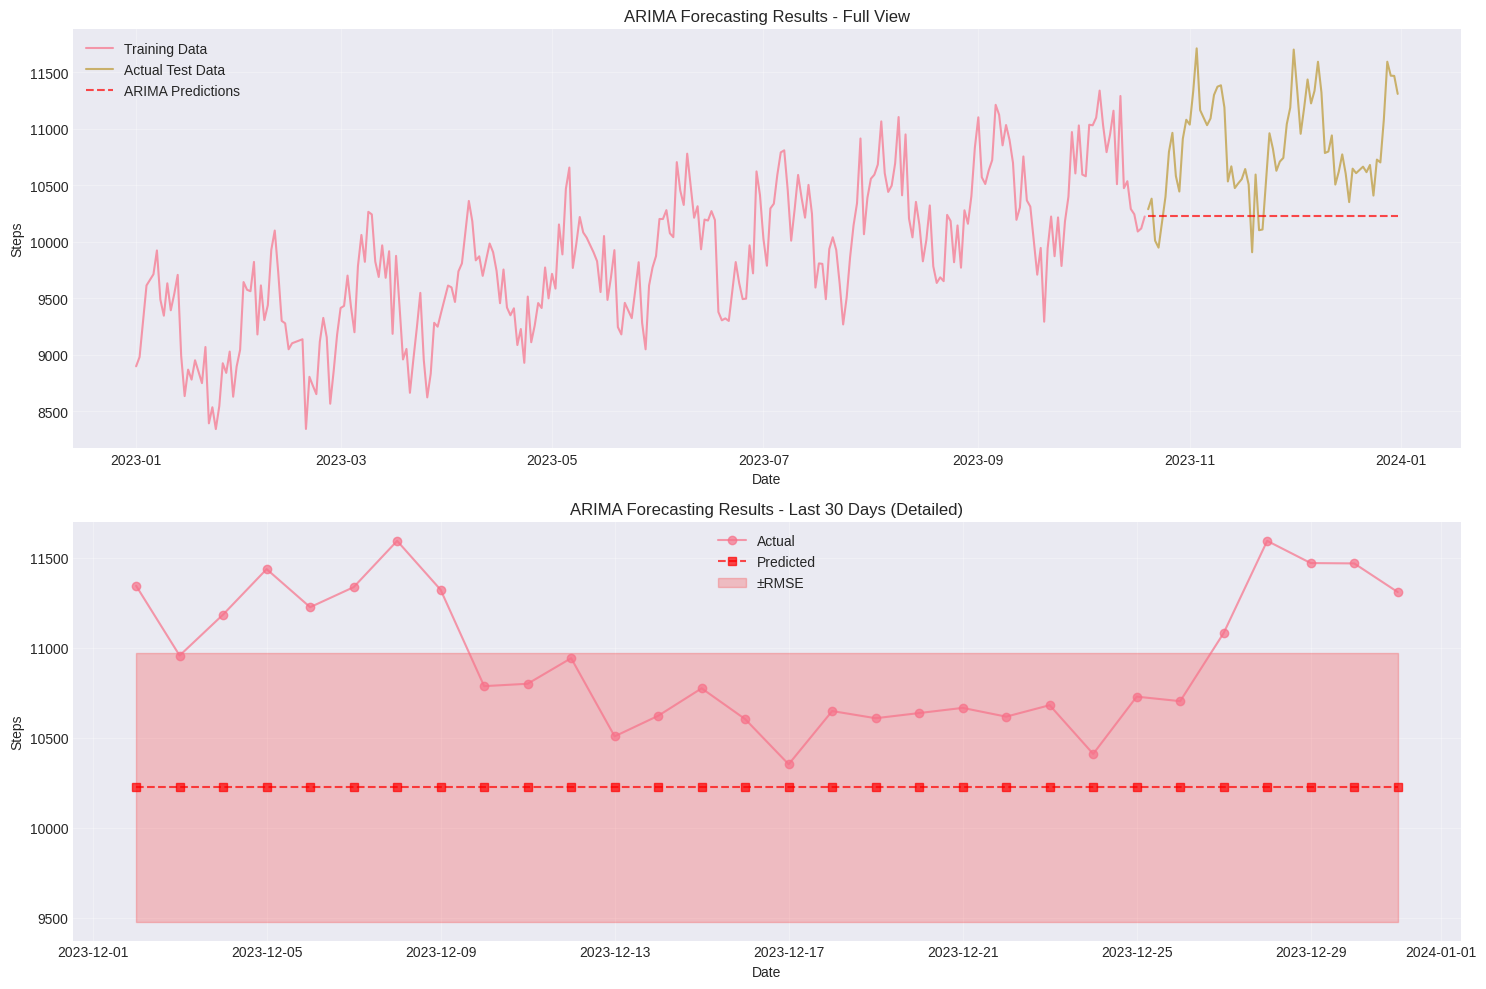

In [13]:
# Visualize predictions
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Full view
axes[0].plot(train_data.index, train_data, label='Training Data', alpha=0.7)
axes[0].plot(test_data.index, test_data, label='Actual Test Data', alpha=0.7)
axes[0].plot(predictions.index, predictions, label='ARIMA Predictions',
             color='red', alpha=0.7, linestyle='--')
axes[0].set_title('ARIMA Forecasting Results - Full View')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Steps')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Zoomed view (last 30 days of test)
axes[1].plot(test_data[-30:].index, test_data[-30:],
             'o-', label='Actual', alpha=0.7)
axes[1].plot(predictions[-30:].index, predictions[-30:],
             's--', label='Predicted', color='red', alpha=0.7)
axes[1].fill_between(predictions[-30:].index,
                      predictions[-30:] - rmse,
                      predictions[-30:] + rmse,
                      alpha=0.2, color='red', label='±RMSE')
axes[1].set_title('ARIMA Forecasting Results - Last 30 Days (Detailed)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Steps')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 🧪 Residual Diagnostics for Steps Forecasts

Good models leave residuals that look like random noise.
This cell:
- Plots residuals over time
- Shows their histogram and Q–Q plot
- Plots the ACF of residuals
- Prints summary statistics

If strong structure remains in residuals, it suggests the ARIMA model could be improved.

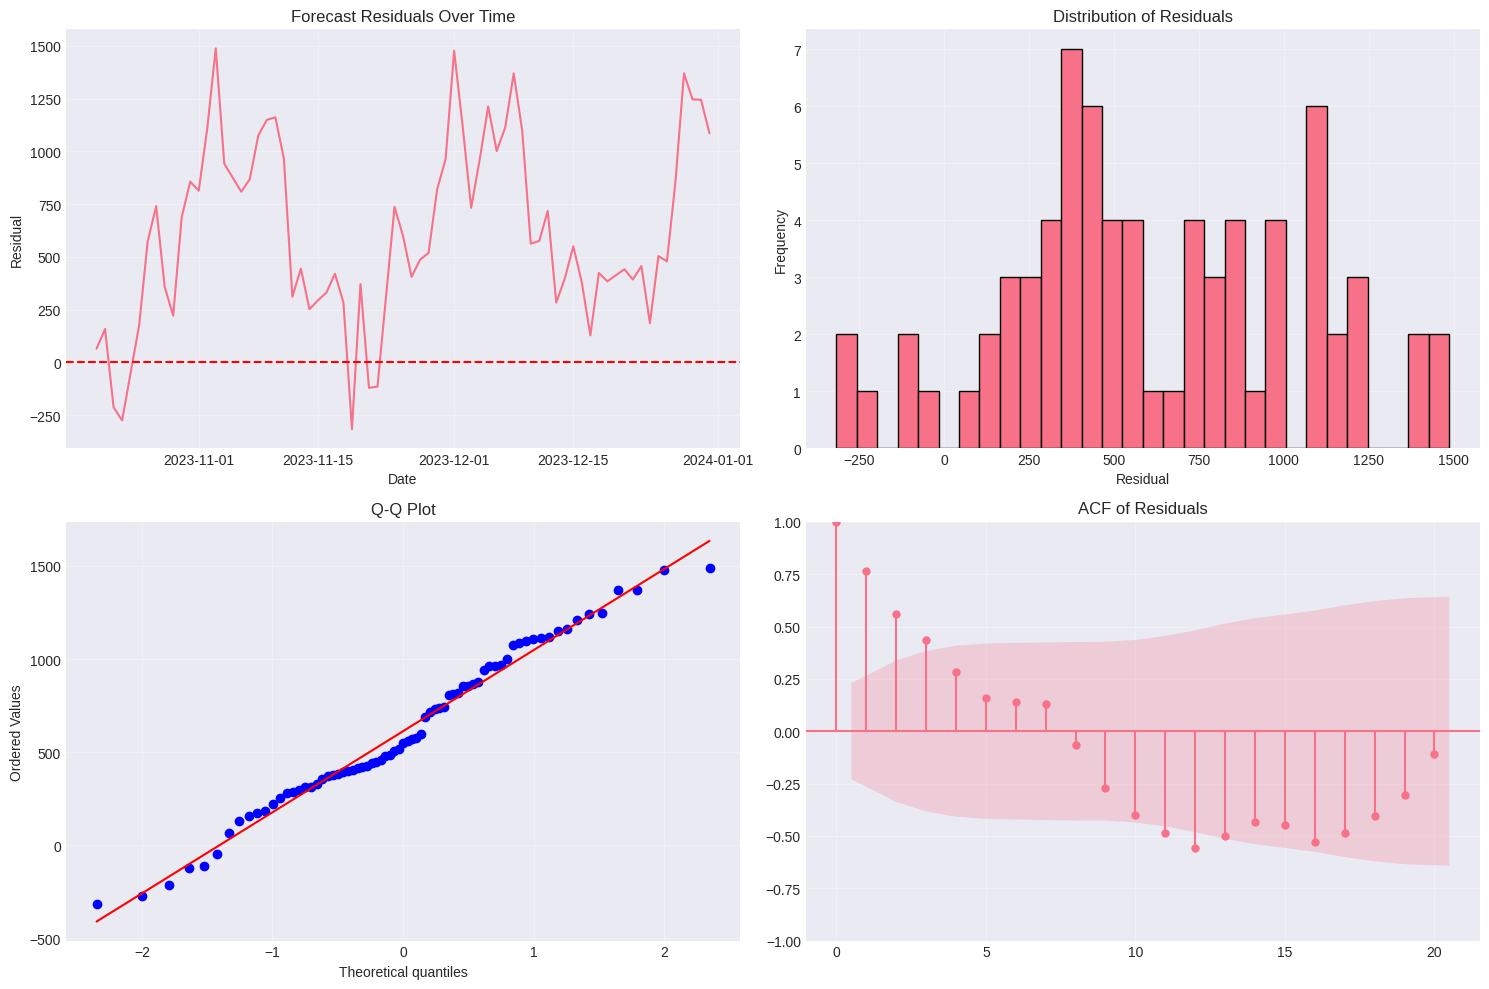

Residual Analysis:
Mean of residuals: 611.96
Std of residuals: 430.50
Skewness: 0.03
Kurtosis: -0.56


In [14]:
# Residual analysis
residuals = test_data - predictions

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Residuals over time
axes[0, 0].plot(residuals.index, residuals)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_title('Forecast Residuals Over Time')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Residual')
axes[0, 0].grid(True, alpha=0.3)

# Histogram of residuals
axes[0, 1].hist(residuals, bins=30, edgecolor='black')
axes[0, 1].set_title('Distribution of Residuals')
axes[0, 1].set_xlabel('Residual')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot')
axes[1, 0].grid(True, alpha=0.3)

# ACF of residuals
plot_acf(residuals.dropna(), lags=20, ax=axes[1, 1])
axes[1, 1].set_title('ACF of Residuals')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical tests on residuals
print("Residual Analysis:")
print(f"Mean of residuals: {residuals.mean():.2f}")
print(f"Std of residuals: {residuals.std():.2f}")
print(f"Skewness: {residuals.skew():.2f}")
print(f"Kurtosis: {residuals.kurtosis():.2f}")

## 4. Example 2: Sleep Pattern Forecasting - "When Will You Actually Sleep?"

In this second example, we'll analyze sleep patterns to predict sleep quality and duration.

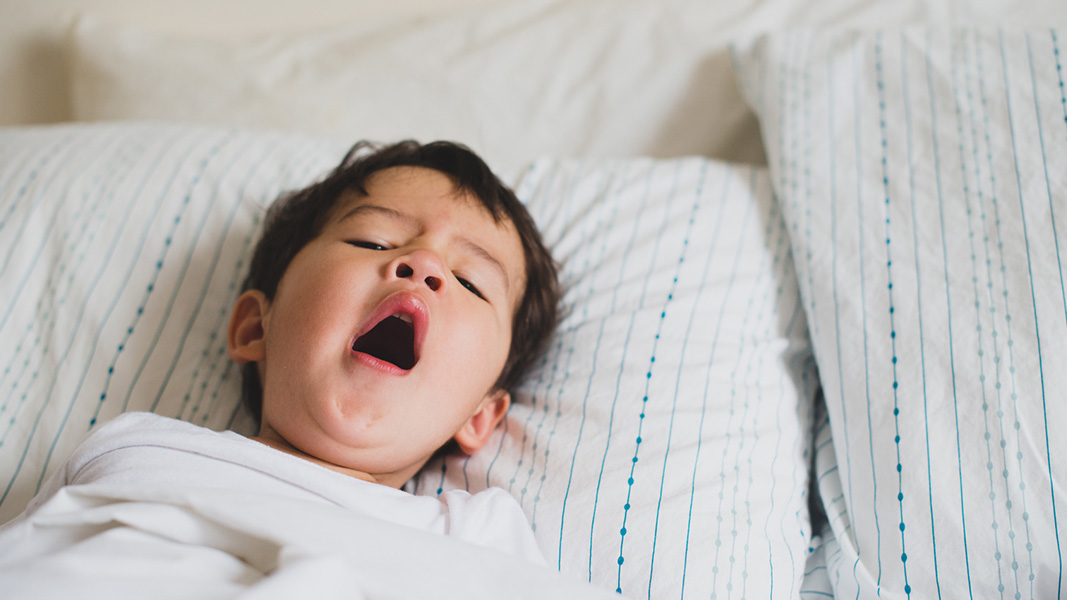

### 😴 Generating Synthetic Sleep Data

This function simulates nightly sleep behavior with:
- **Sleep duration** patterns (less on weekdays, more on weekends and in winter)
- A **sleep quality score** correlated with duration
- Split of total sleep into **REM**, **deep**, and **light** stages
- A small amount of missing data

The result `sleep_df` becomes the core dataset for Example 2.

In [15]:
# Generate synthetic sleep data
def generate_sleep_data(start_date='2023-01-01', periods=365):
    """
    Generate synthetic sleep tracking data with realistic patterns.

    Parameters:
    -----------
    start_date : str
        Starting date for the time series
    periods : int
        Number of days to generate

    Returns:
    --------
    pd.DataFrame
        DataFrame with sleep metrics
    """
    dates = pd.date_range(start=start_date, periods=periods, freq='D')

    # Base sleep duration (7-8 hours)
    base_sleep = 7.5

    # Weekly pattern (less sleep on weekdays)
    weekly_pattern = np.array([6.8, 6.9, 7.0, 7.1, 7.5, 8.5, 8.2])
    weekly_effect = np.tile(weekly_pattern, periods//7 + 1)[:periods]

    # Seasonal pattern (more sleep in winter)
    seasonal = np.sin(np.arange(periods) * 2 * np.pi / 365 - np.pi/2) * 0.5

    # Random variation
    noise = np.random.normal(0, 0.5, periods)

    # Combine components
    sleep_hours = weekly_effect + seasonal + noise
    sleep_hours = np.clip(sleep_hours, 4, 12)  # Realistic bounds

    # Sleep quality score (0-100)
    # Correlated with duration but with its own variation
    quality_base = sleep_hours * 10 + 15
    quality = quality_base + np.random.normal(0, 5, periods)
    quality = np.clip(quality, 0, 100)

    # REM sleep (correlated with total sleep)
    rem_percentage = 20 + np.random.normal(0, 3, periods)
    rem_hours = sleep_hours * rem_percentage / 100

    # Deep sleep (also correlated)
    deep_percentage = 15 + np.random.normal(0, 2, periods)
    deep_hours = sleep_hours * deep_percentage / 100

    # Add some missing values
    missing_mask = np.random.random(periods) < 0.03
    sleep_hours[missing_mask] = np.nan
    quality[missing_mask] = np.nan

    # Create DataFrame
    df = pd.DataFrame({
        'date': dates,
        'sleep_hours': sleep_hours,
        'sleep_quality': quality,
        'rem_hours': rem_hours,
        'deep_hours': deep_hours,
        'light_hours': sleep_hours - rem_hours - deep_hours
    })
    df.set_index('date', inplace=True)

    return df

# Generate sleep data
sleep_df = generate_sleep_data()
print("Sleep Data Shape:", sleep_df.shape)
print("\nFirst 10 rows:")
sleep_df.head(10)

Sleep Data Shape: (365, 5)

First 10 rows:


,sleep_hours,sleep_quality,rem_hours,deep_hours,light_hours
date,,,,,
2023-01-01,6.760675,73.180748,1.355181,1.087482,4.318011
2023-01-02,7.105358,84.572244,1.535765,0.918174,4.651419
2023-01-03,7.107536,78.043474,1.412620,1.085423,4.609493
2023-01-04,6.738938,86.285554,1.755744,1.033067,3.950127
2023-01-05,7.400934,94.259898,1.528215,1.007362,4.865357
2023-01-06,NaN,NaN,1.779124,1.202936,NaN
2023-01-07,7.786862,95.010187,1.388367,1.011075,5.387420
2023-01-08,5.707981,76.575484,1.162274,0.728672,3.817034
2023-01-09,6.436076,83.873111,1.586024,0.978233,3.871820


### 👀 Exploring Fitness Data Over Time

This cell performs basic **exploratory data analysis** for the fitness data:
- Plots **steps**, **active minutes**, and **calories** across the year
- Prints summary statistics and counts missing values

Use these plots to visually inspect trends, seasonality, and outliers before modeling.

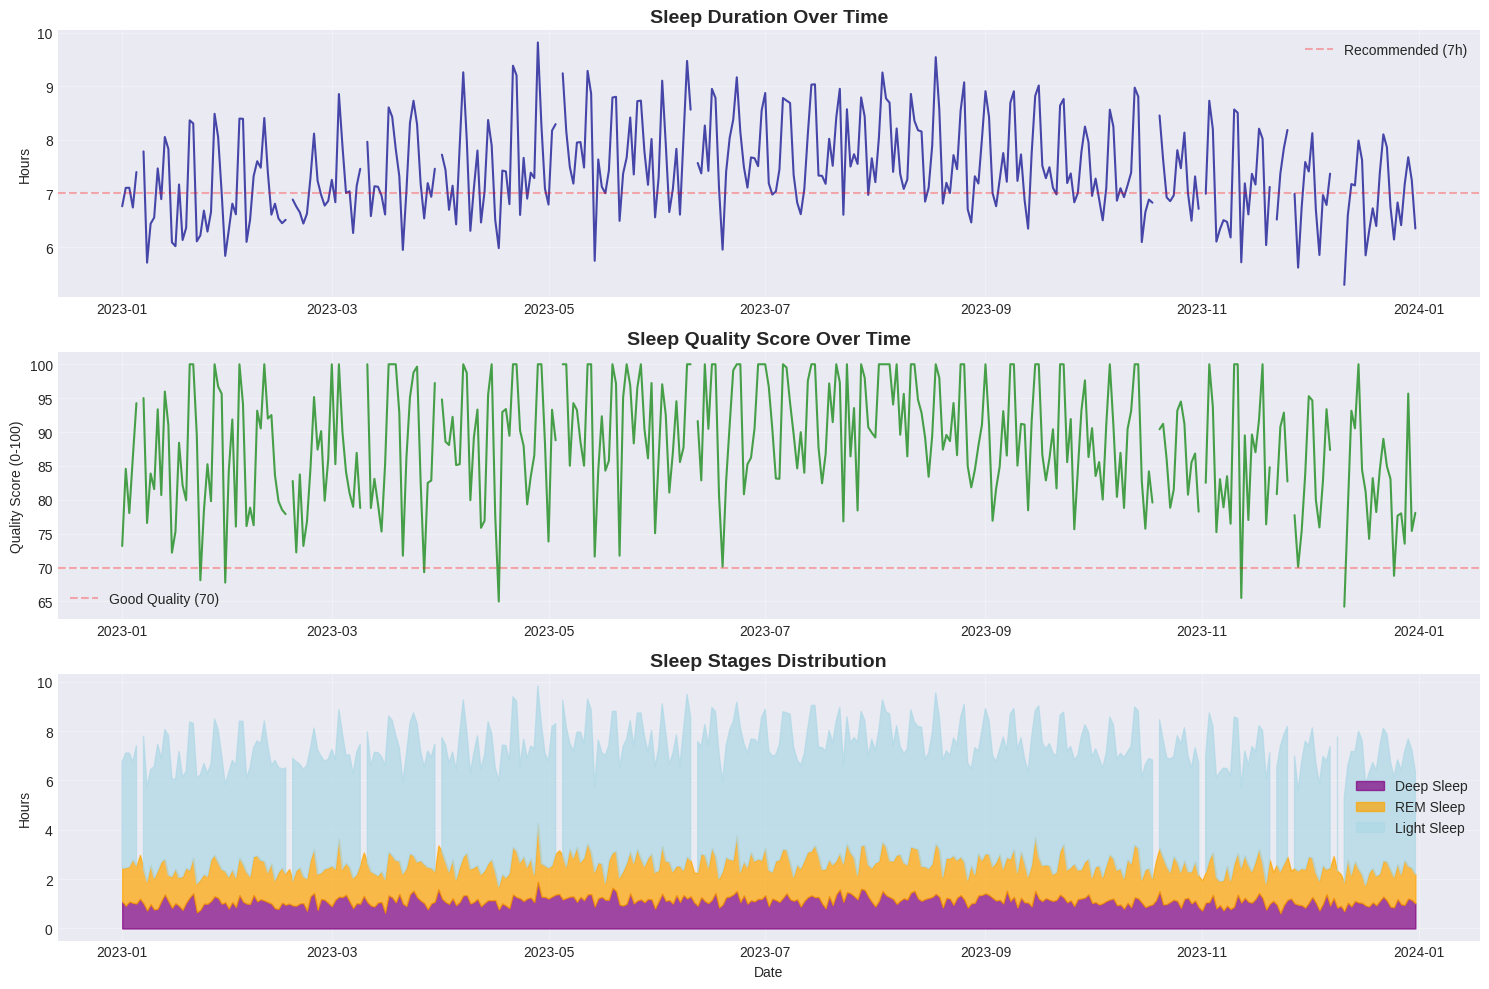


Sleep Statistics Summary:
       sleep_hours  sleep_quality   rem_hours  deep_hours  light_hours
count   353.000000     353.000000  365.000000  365.000000   353.000000
mean      7.445591      88.329539    1.482942    1.117336     4.846593
std       0.861157       8.685439    0.276120    0.198779     0.615801
min       5.293820      64.228174    0.671495    0.615485     3.258192
25%       6.832355      82.505346    1.276877    0.995749     4.364300
50%       7.325845      88.576854    1.457685    1.111981     4.755175
75%       8.055651      95.634130    1.664645    1.251458     5.294830
max       9.821572     100.000000    2.370547    1.887733     6.575639


In [16]:
# Visualize sleep patterns
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Sleep hours
axes[0].plot(sleep_df.index, sleep_df['sleep_hours'], alpha=0.7, color='darkblue')
axes[0].axhline(y=7, color='r', linestyle='--', alpha=0.3, label='Recommended (7h)')
axes[0].set_title('Sleep Duration Over Time', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Hours')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Sleep quality
axes[1].plot(sleep_df.index, sleep_df['sleep_quality'], alpha=0.7, color='green')
axes[1].axhline(y=70, color='r', linestyle='--', alpha=0.3, label='Good Quality (70)')
axes[1].set_title('Sleep Quality Score Over Time', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Quality Score (0-100)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Sleep stages stacked
axes[2].fill_between(sleep_df.index, 0, sleep_df['deep_hours'],
                     alpha=0.7, color='purple', label='Deep Sleep')
axes[2].fill_between(sleep_df.index, sleep_df['deep_hours'],
                     sleep_df['deep_hours'] + sleep_df['rem_hours'],
                     alpha=0.7, color='orange', label='REM Sleep')
axes[2].fill_between(sleep_df.index,
                     sleep_df['deep_hours'] + sleep_df['rem_hours'],
                     sleep_df['sleep_hours'],
                     alpha=0.7, color='lightblue', label='Light Sleep')
axes[2].set_title('Sleep Stages Distribution', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Hours')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nSleep Statistics Summary:")
print(sleep_df.describe())

### 📅 Weekly Patterns in Sleep

Here we add `day_of_week` and `is_weekend` columns and then:
- Compute average **sleep hours** and **sleep quality** by weekday
- Visualize these with bar charts and error bars

This reveals how your sleep behavior changes across the week.

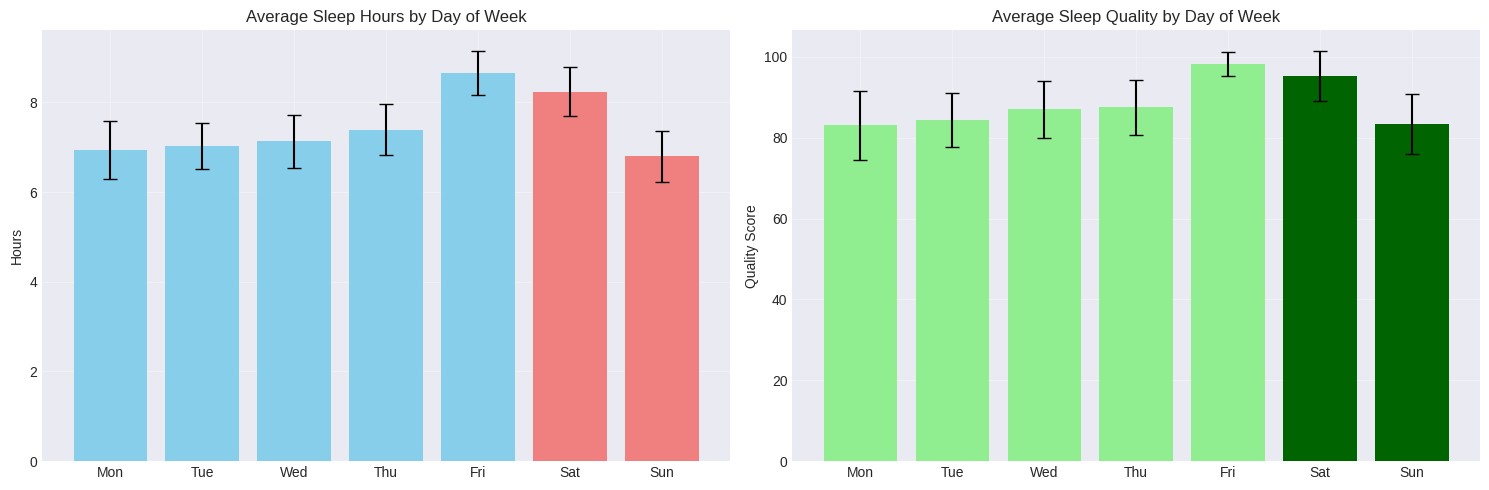


Weekly Sleep Patterns:
            sleep_hours           sleep_quality          
                   mean       std          mean       std
day_of_week                                              
0              6.936155  0.638934     83.060058  8.520743
1              7.035818  0.510232     84.329083  6.664106
2              7.131624  0.593062     87.014781  7.008999
3              7.395338  0.576019     87.501813  6.722364
4              8.657886  0.492872     98.348543  2.981876
5              8.243219  0.549482     95.263339  6.241120
6              6.794784  0.575685     83.430029  7.510068


In [17]:
# Analyze weekly patterns
sleep_df['day_of_week'] = sleep_df.index.dayofweek
sleep_df['is_weekend'] = (sleep_df['day_of_week'] >= 5).astype(int)

# Weekly analysis
weekly_stats = sleep_df.groupby('day_of_week').agg({
    'sleep_hours': ['mean', 'std'],
    'sleep_quality': ['mean', 'std']
})

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Sleep hours by day of week
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0].bar(range(7), weekly_stats['sleep_hours']['mean'],
            yerr=weekly_stats['sleep_hours']['std'], capsize=5,
            color=['skyblue']*5 + ['lightcoral']*2)
axes[0].set_xticks(range(7))
axes[0].set_xticklabels(days)
axes[0].set_title('Average Sleep Hours by Day of Week')
axes[0].set_ylabel('Hours')
axes[0].grid(True, alpha=0.3)

# Sleep quality by day of week
axes[1].bar(range(7), weekly_stats['sleep_quality']['mean'],
            yerr=weekly_stats['sleep_quality']['std'], capsize=5,
            color=['lightgreen']*5 + ['darkgreen']*2)
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(days)
axes[1].set_title('Average Sleep Quality by Day of Week')
axes[1].set_ylabel('Quality Score')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nWeekly Sleep Patterns:")
print(weekly_stats)

### 4.1 Advanced Forecasting with Multiple Models

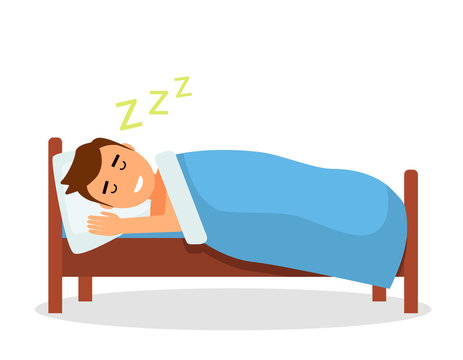

### 🧼 Cleaning Sleep Hours for Modeling

We interpolate missing `sleep_hours` values to create a continuous series, then:
- Split it into training (80%) and test (20%) sets

This mirrors the steps example, but now for sleep forecasting.

In [18]:
# Prepare data for modeling
sleep_df['sleep_hours_clean'] = sleep_df['sleep_hours'].interpolate(method='linear')

# Split data
train_size = int(len(sleep_df) * 0.8)
train_sleep = sleep_df['sleep_hours_clean'][:train_size]
test_sleep = sleep_df['sleep_hours_clean'][train_size:]

print(f"Training set: {len(train_sleep)} days")
print(f"Test set: {len(test_sleep)} days")

Training set: 292 days
Test set: 73 days


### 🧠 Comparing Multiple Forecasting Models (Sleep)

The `ForecastingModels` class wraps several approaches:
- **Naive** (last value)
- **Moving average** with different windows
- **Simple exponential smoothing**
- **Holt‑Winters** with trend + seasonality
- **ARIMA** with a fixed order

We generate predictions for each model and compute MAE, RMSE, and MAPE to compare them fairly.

In [19]:
# Implement multiple forecasting models
from statsmodels.tsa.holtwinters import ExponentialSmoothing

class ForecastingModels:
    """
    Class to implement and compare multiple forecasting models.
    """

    def __init__(self, train_data, test_data):
        self.train = train_data
        self.test = test_data
        self.predictions = {}
        self.metrics = {}

    def naive_forecast(self):
        """Last value forecast"""
        pred = np.repeat(self.train.iloc[-1], len(self.test))
        self.predictions['Naive'] = pd.Series(pred, index=self.test.index)
        return self.predictions['Naive']

    def moving_average(self, window=7):
        """Simple moving average forecast"""
        ma_value = self.train[-window:].mean()
        pred = np.repeat(ma_value, len(self.test))
        self.predictions[f'MA({window})'] = pd.Series(pred, index=self.test.index)
        return self.predictions[f'MA({window})']

    def exponential_smoothing(self, alpha=0.3):
        """Simple exponential smoothing"""
        model = ExponentialSmoothing(self.train, trend=None, seasonal=None)
        model_fit = model.fit(smoothing_level=alpha)
        pred = model_fit.forecast(len(self.test))
        self.predictions[f'ExpSmooth(α={alpha})'] = pred
        return pred

    def holt_winters(self, seasonal_periods=7):
        """Holt-Winters with seasonality"""
        model = ExponentialSmoothing(self.train,
                                      trend='add',
                                      seasonal='add',
                                      seasonal_periods=seasonal_periods)
        model_fit = model.fit()
        pred = model_fit.forecast(len(self.test))
        self.predictions['Holt-Winters'] = pred
        return pred

    def arima_forecast(self, order=(1,1,1)):
        """ARIMA forecast"""
        model = ARIMA(self.train, order=order)
        model_fit = model.fit()
        pred = model_fit.forecast(steps=len(self.test))
        pred.index = self.test.index
        self.predictions[f'ARIMA{order}'] = pred
        return pred

    def calculate_metrics(self):
        """Calculate performance metrics for all models"""
        for name, pred in self.predictions.items():
            mae = mean_absolute_error(self.test, pred)
            rmse = np.sqrt(mean_squared_error(self.test, pred))
            mape = np.mean(np.abs((self.test - pred) / self.test)) * 100
            self.metrics[name] = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}
        return self.metrics

# Initialize and run models
models = ForecastingModels(train_sleep, test_sleep)

# Run different models
print("Running forecasting models...")
models.naive_forecast()
models.moving_average(7)
models.moving_average(14)
models.exponential_smoothing(0.3)
models.holt_winters(7)
models.arima_forecast((2,0,1))

# Calculate metrics
metrics = models.calculate_metrics()

# Display results
metrics_df = pd.DataFrame(metrics).T
metrics_df = metrics_df.sort_values('RMSE')
print("\nModel Performance Comparison:")
print(metrics_df.round(3))

Running forecasting models...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat


Model Performance Comparison:
                    MAE   RMSE    MAPE
Holt-Winters      0.360  0.456   5.263
ExpSmooth(α=0.3)  0.633  0.769   9.235
MA(7)             0.679  0.822  10.109
MA(14)            0.688  0.833  10.275
ARIMA(2, 0, 1)    0.721  0.872  10.845
Naive             0.774  0.935  11.699


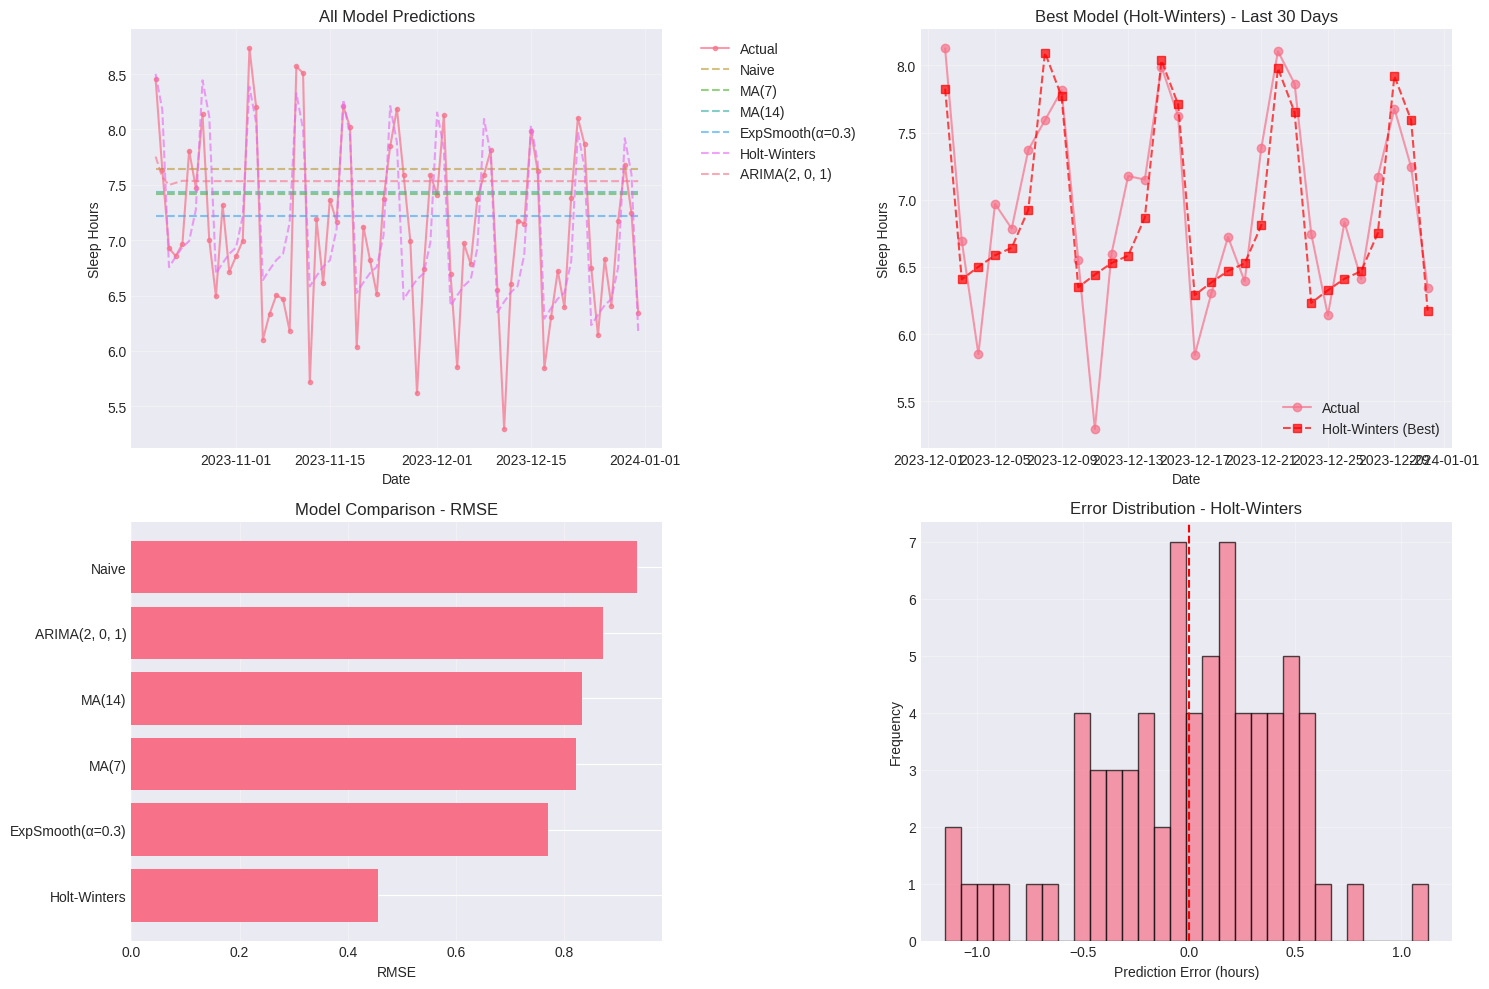

In [20]:
# Visualize model comparisons
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot all predictions
axes[0, 0].plot(test_sleep.index, test_sleep, 'o-', label='Actual', alpha=0.7, markersize=3)
for name, pred in models.predictions.items():
    axes[0, 0].plot(test_sleep.index, pred, '--', label=name, alpha=0.6)
axes[0, 0].set_title('All Model Predictions')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Sleep Hours')
axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 0].grid(True, alpha=0.3)

# Best model detailed view
best_model = metrics_df.index[0]
axes[0, 1].plot(test_sleep[-30:].index, test_sleep[-30:], 'o-', label='Actual', alpha=0.7)
axes[0, 1].plot(test_sleep[-30:].index, models.predictions[best_model][-30:],
                's--', label=f'{best_model} (Best)', color='red', alpha=0.7)
axes[0, 1].set_title(f'Best Model ({best_model}) - Last 30 Days')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Sleep Hours')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Metrics comparison bar chart
metrics_for_plot = metrics_df.sort_values('RMSE', ascending=True)
x_pos = np.arange(len(metrics_for_plot))
axes[1, 0].barh(x_pos, metrics_for_plot['RMSE'])
axes[1, 0].set_yticks(x_pos)
axes[1, 0].set_yticklabels(metrics_for_plot.index)
axes[1, 0].set_xlabel('RMSE')
axes[1, 0].set_title('Model Comparison - RMSE')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Error distribution for best model
best_errors = test_sleep - models.predictions[best_model]
axes[1, 1].hist(best_errors, bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(x=0, color='r', linestyle='--')
axes[1, 1].set_title(f'Error Distribution - {best_model}')
axes[1, 1].set_xlabel('Prediction Error (hours)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.2 Cross-Validation for Time Series

### 🔁 Time Series Cross‑Validation

Instead of random k‑fold CV, this function uses **`TimeSeriesSplit`** to:
- Train on earlier time windows
- Test on later windows of fixed size

We then evaluate different models (like MA(7) and ARIMA(1,0,1)) across folds to see how stable their performance is over time.

In [21]:
def time_series_cv(data, n_splits=5, test_size=30):
    """
    Perform time series cross-validation.

    Parameters:
    -----------
    data : pd.Series
        Time series data
    n_splits : int
        Number of CV splits
    test_size : int
        Size of test set in each split

    Returns:
    --------
    list
        List of (train_idx, test_idx) tuples
    """
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
    splits = []

    for train_idx, test_idx in tscv.split(data):
        if len(train_idx) > 50:  # Ensure minimum training size
            splits.append((train_idx, test_idx))

    return splits

# Perform cross-validation
cv_results = {'Model': [], 'Fold': [], 'MAE': [], 'RMSE': []}

# Get CV splits
cv_splits = time_series_cv(sleep_df['sleep_hours_clean'], n_splits=5)

print(f"Performing {len(cv_splits)}-fold time series cross-validation...\n")

# Test multiple models with CV
model_configs = [
    ('MA(7)', lambda train: np.repeat(train[-7:].mean(), 30)),
    ('ARIMA(1,0,1)', lambda train: ARIMA(train, order=(1,0,1)).fit().forecast(30))
]

for model_name, model_func in model_configs:
    print(f"Testing {model_name}...")

    for fold, (train_idx, test_idx) in enumerate(cv_splits):
        # Get train and test data
        train_data = sleep_df['sleep_hours_clean'].iloc[train_idx]
        test_data = sleep_df['sleep_hours_clean'].iloc[test_idx]

        try:
            # Make predictions
            predictions = model_func(train_data)

            # Calculate metrics
            mae = mean_absolute_error(test_data, predictions[:len(test_data)])
            rmse = np.sqrt(mean_squared_error(test_data, predictions[:len(test_data)]))

            cv_results['Model'].append(model_name)
            cv_results['Fold'].append(fold + 1)
            cv_results['MAE'].append(mae)
            cv_results['RMSE'].append(rmse)
        except:
            pass

# Display CV results
cv_df = pd.DataFrame(cv_results)
cv_summary = cv_df.groupby('Model')[['MAE', 'RMSE']].agg(['mean', 'std'])
print("\nCross-Validation Results:")
print(cv_summary.round(3))

Performing 5-fold time series cross-validation...

Testing MA(7)...
Testing ARIMA(1,0,1)...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat


Cross-Validation Results:
                MAE          RMSE       
               mean    std   mean    std
Model                                   
ARIMA(1,0,1)  0.692  0.070  0.828  0.085
MA(7)         0.650  0.061  0.773  0.063


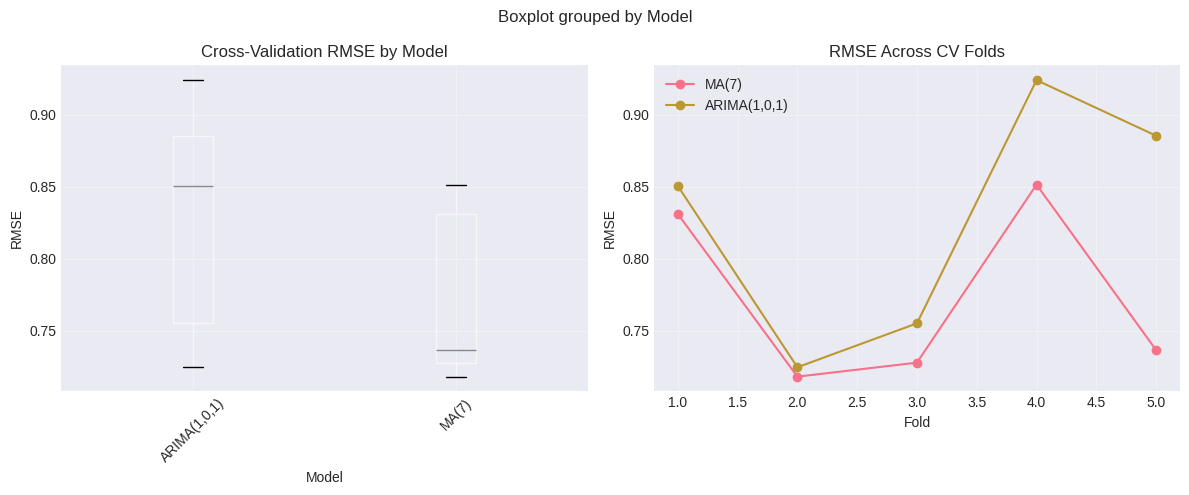

In [22]:
# Visualize CV results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Box plot of RMSE by model
cv_df.boxplot(column='RMSE', by='Model', ax=axes[0])
axes[0].set_title('Cross-Validation RMSE by Model')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('RMSE')
axes[0].grid(True, alpha=0.3)
plt.sca(axes[0])
plt.xticks(rotation=45)

# Line plot showing performance across folds
for model in cv_df['Model'].unique():
    model_data = cv_df[cv_df['Model'] == model]
    axes[1].plot(model_data['Fold'], model_data['RMSE'], 'o-', label=model)
axes[1].set_title('RMSE Across CV Folds')
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('RMSE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.3 Future Predictions with Confidence Intervals

### 🔮 Final 30‑Day Sleep Forecast with Confidence Intervals

This cell fits an ARIMA(2,0,1) model on **all cleaned sleep data** and:
- Forecasts the next 30 days of sleep duration
- Computes 95% confidence intervals for each forecasted day

The resulting `forecast_df` summarizes the expected future pattern and its uncertainty.

In [23]:
# Train final model on all data and make future predictions
final_sleep_model = ARIMA(sleep_df['sleep_hours_clean'], order=(2,0,1))
final_sleep_fit = final_sleep_model.fit()

# Forecast next 30 days
forecast_horizon = 30
forecast_result = final_sleep_fit.forecast(steps=forecast_horizon)
forecast_ci = final_sleep_fit.get_forecast(steps=forecast_horizon).conf_int()

# Create future dates
last_date = sleep_df.index[-1]
future_dates = pd.date_range(start=last_date + timedelta(days=1),
                              periods=forecast_horizon, freq='D')

# Create forecast DataFrame
forecast_df = pd.DataFrame({
    'forecast': forecast_result,
    'lower_bound': forecast_ci.iloc[:, 0],
    'upper_bound': forecast_ci.iloc[:, 1]
}, index=future_dates)

print("30-Day Sleep Forecast:")
print(forecast_df.head(10))
print("\nForecast Statistics:")
print(f"Average predicted sleep: {forecast_df['forecast'].mean():.2f} hours")
print(f"Min predicted sleep: {forecast_df['forecast'].min():.2f} hours")
print(f"Max predicted sleep: {forecast_df['forecast'].max():.2f} hours")

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


30-Day Sleep Forecast:
            forecast  lower_bound  upper_bound
2024-01-01  7.002857     5.498018     8.507697
2024-01-02  7.527767     5.863291     9.192243
2024-01-03  7.521592     5.854352     9.188833
2024-01-04  7.445756     5.774390     9.117122
2024-01-05  7.434004     5.762628     9.105380
2024-01-06  7.442854     5.771404     9.114305
2024-01-07  7.446003     5.774549     9.117457
2024-01-08  7.445267     5.773812     9.116722
2024-01-09  7.444695     5.773240     9.116150
2024-01-10  7.444705     5.773250     9.116160

Forecast Statistics:
Average predicted sleep: 7.44 hours
Min predicted sleep: 7.00 hours
Max predicted sleep: 7.53 hours


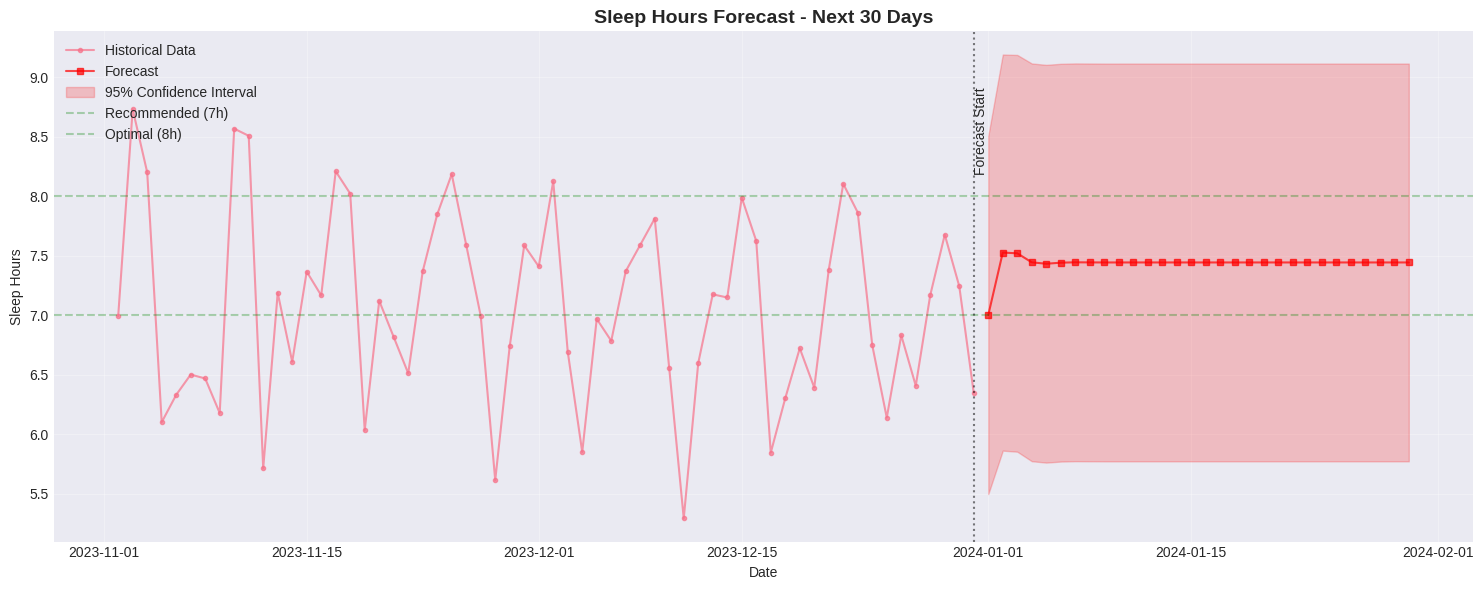

In [24]:
# Visualize future predictions
fig, ax = plt.subplots(figsize=(15, 6))

# Plot historical data
ax.plot(sleep_df.index[-60:], sleep_df['sleep_hours_clean'][-60:],
        'o-', label='Historical Data', alpha=0.7, markersize=3)

# Plot forecast
ax.plot(forecast_df.index, forecast_df['forecast'],
        's-', color='red', label='Forecast', alpha=0.7, markersize=4)

# Add confidence intervals
ax.fill_between(forecast_df.index,
                 forecast_df['lower_bound'],
                 forecast_df['upper_bound'],
                 color='red', alpha=0.2, label='95% Confidence Interval')

# Add recommended sleep line
ax.axhline(y=7, color='green', linestyle='--', alpha=0.3, label='Recommended (7h)')
ax.axhline(y=8, color='green', linestyle='--', alpha=0.3, label='Optimal (8h)')

# Formatting
ax.set_title('Sleep Hours Forecast - Next 30 Days', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Sleep Hours')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# Add vertical line to separate historical and forecast
ax.axvline(x=sleep_df.index[-1], color='black', linestyle=':', alpha=0.5)
ax.text(sleep_df.index[-1], ax.get_ylim()[1]*0.95, 'Forecast Start',
        rotation=90, verticalalignment='top')

plt.tight_layout()
plt.show()

## 5. Exercises

Now it's your turn to practice! Use the following exercises to reinforce your understanding of time series forecasting.

### Exercise 1: Fitness Data Analysis
1. Load the fitness data and identify any monthly patterns
2. Apply seasonal decomposition with a 30-day period
3. Build a SARIMA model to capture both weekly and monthly seasonality
4. Compare the performance with the basic ARIMA model

### Exercise 2: Sleep Quality Prediction
1. Use the sleep quality score as your target variable
2. Create lag features for both sleep hours and quality
3. Implement a moving average model with optimal window size
4. Forecast sleep quality for the next 14 days

### Exercise 3: Combined Analysis
1. Investigate the correlation between fitness activity and sleep patterns
2. Create a multivariate time series model
3. Predict both metrics simultaneously
4. Visualize the relationship between predicted values

### 🧪 Exercise Workspace

This final cell is a **sandbox** for you to practice:
- Analyze monthly patterns in the fitness data
- Try 30‑day seasonal decomposition
- Experiment with SARIMA and compare it against ARIMA

You can fill in the TODOs or extend this area to test your own ideas.

In [25]:
# Exercise workspace - Your code here
# Hint: Start by loading the data and exploring patterns

# Example starter code for Exercise 1
print("Exercise 1: Monthly Pattern Analysis")
print("="*50)

# TODO: Your implementation here
# 1. Identify monthly patterns
# fitness_df['month'] = fitness_df.index.month
# monthly_avg = fitness_df.groupby('month')['steps_clean'].mean()

# 2. Apply 30-day seasonal decomposition
# decomp_monthly = seasonal_decompose(fitness_df['steps_clean'], model='additive', period=30)

# 3. Build SARIMA model
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# sarima_model = SARIMAX(train_data, order=(1,1,1), seasonal_order=(1,1,1,7))

print("\nAdd your solution above!")

Exercise 1: Monthly Pattern Analysis

Add your solution above!


## 📘 Forecasting Quiz

Test your understanding of the core concepts from the *Crash Course in Forecasting*!  
This short quiz covers:

- Stationarity and differencing  
- Time series components (trend, seasonality, residuals)  
- ARIMA and Holt-Winters methods  
- Forecast evaluation metrics  
- Cross-validation for time series  
- Handling missing values  
- Model comparison and uncertainty

Click the quiz link or use the embedded form to begin.  
Good luck — and have fun learning! 🚀


In [28]:
from IPython.display import HTML

HTML("""
<div data-tf-live="01KAJ75RKJF0FX00PR0GP4E409"></div>
<script src="//embed.typeform.com/next/embed.js"></script>
""")


## 6. Conclusion

In this comprehensive crash course on forecasting, we've covered essential concepts and practical techniques for time series analysis and prediction. Here are the key takeaways:

### Key Learnings:

1. **Data Preparation is Critical**: Handling missing values appropriately and ensuring stationarity are fundamental steps that significantly impact forecast accuracy.

2. **Understanding Patterns**: Time series data contains multiple components (trend, seasonality, cyclical patterns, and noise) that must be identified and modeled appropriately.

3. **Feature Engineering Matters**: Creating relevant features like lag variables, rolling statistics, and time-based features can dramatically improve model performance.

4. **Model Selection**: Different models excel in different scenarios:
   - Simple methods (Moving Average, Exponential Smoothing) work well for stable patterns
   - ARIMA models handle complex autocorrelation structures
   - Seasonal models (SARIMA, Holt-Winters) capture recurring patterns

5. **Validation is Essential**: Time series cross-validation respects temporal ordering and provides robust performance estimates.

6. **Practical Applications**: Real-world forecasting requires:
   - Understanding domain context
   - Handling edge cases and anomalies
   - Providing confidence intervals for decision-making
   - Regular model updates and monitoring

### Best Practices:

- Always visualize your data before modeling
- Test for stationarity and transform if necessary
- Start with simple models as baselines
- Use multiple evaluation metrics
- Consider ensemble methods for robust predictions
- Document assumptions and limitations

### Future Directions:

As you continue your forecasting journey, consider exploring:
- Deep learning approaches (LSTM, GRU, Transformer models)
- Prophet for handling holidays and changepoints
- Multivariate time series analysis (VAR, VARMAX)
- Online learning for adaptive forecasting
- Probabilistic forecasting for uncertainty quantification

Remember: Good forecasting is as much art as science. Domain knowledge, careful data preparation, and iterative refinement are just as important as sophisticated algorithms.

## 7. References

1. Box, G. E., Jenkins, G. M., Reinsel, G. C., & Ljung, G. M. (2015). *Time series analysis: forecasting and control*. John Wiley & Sons.

2. Hyndman, R. J., & Athanasopoulos, G. (2021). *Forecasting: principles and practice* (3rd ed). OTexts. Available at: https://otexts.com/fpp3/

3. Brockwell, P. J., & Davis, R. A. (2016). *Introduction to time series and forecasting*. Springer.

4. Cleveland, R. B., Cleveland, W. S., McRae, J. E., & Terpenning, I. (1990). STL: A seasonal-trend decomposition procedure based on loess. *Journal of Official Statistics*, 6(1), 3-73.

5. Taylor, S. J., & Letham, B. (2018). Forecasting at scale. *The American Statistician*, 72(1), 37-45.

6. Makridakis, S., Spiliotis, E., & Assimakopoulos, V. (2018). Statistical and Machine Learning forecasting methods: Concerns and ways forward. *PLOS ONE*, 13(3), e0194889.

7. De Gooijer, J. G., & Hyndman, R. J. (2006). 25 years of time series forecasting. *International Journal of Forecasting*, 22(3), 443-473.

8. Chatfield, C. (2000). *Time-series forecasting*. CRC Press.

## 8. Citations

### Academic Papers:
- Dickey, D. A., & Fuller, W. A. (1979). Distribution of the estimators for autoregressive time series with a unit root. *Journal of the American Statistical Association*, 74(366a), 427-431.

- Kwiatkowski, D., Phillips, P. C., Schmidt, P., & Shin, Y. (1992). Testing the null hypothesis of stationarity against the alternative of a unit root. *Journal of Econometrics*, 54(1-3), 159-178.

### Software and Libraries:
- McKinney, W. (2010). Data structures for statistical computing in python. In *Proceedings of the 9th Python in Science Conference* (Vol. 445, pp. 51-56).

- Seabold, S., & Perktold, J. (2010). Statsmodels: Econometric and statistical modeling with python. In *Proceedings of the 9th Python in Science Conference* (Vol. 57, p. 61).

- Pedregosa, F., et al. (2011). Scikit-learn: Machine learning in Python. *Journal of Machine Learning Research*, 12, 2825-2830.

## 9. License

This educational material is released under the Creative Commons Attribution 4.0 International License (CC BY 4.0).

### You are free to:
- **Share** — copy and redistribute the material in any medium or format
- **Adapt** — remix, transform, and build upon the material for any purpose, even commercially

### Under the following terms:
- **Attribution** — You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.

### Code License:
All code snippets in this notebook are additionally available under the MIT License:

```
MIT License

Copyright (c) 2024 Data Science Course Team

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```

### Dataset License:
The synthetic datasets generated in this notebook are released into the public domain (CC0 1.0 Universal).

---

**Last Updated:** November 2025  

**Contact:** kondoju.m@northeastern.edu
